In [164]:
from __future__ import print_function

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import re

In [165]:
def visualize_case(files, title, show_methods=None, name_map={}, sizes=None):
    plt.figure(figsize=(8,6))

    datas = []
    if sizes is None:
        sizes = [2**(3+i) for i in range(len(files))]

    for ns in sizes:
        found = None
        for path in files:
            if 'train_cnt{}'.format(ns) in path:
                found = path
        with open(found, 'r') as f:
            data = json.load(f)
            datas.append(data)

    keys = sorted(datas[0].keys())
    legend = []
    
    if show_methods is None:
        show_mehtods = keys

    for k in show_methods:
        mas = [data[k]['mean'] if 'mean' in data[k] else data[k]['test_score'] for data in datas]
        legend.append(k)
        plt.plot(mas)
    
    legend = [name_map[x] if x in name_map else x for x in legend]
    plt.legend(legend)
    plt.xticks(range(len(sizes)), sizes)
    plt.title(title)
    plt.xlabel('number of samples')
    plt.ylabel('average negative log-likelihood')
    plt.show()

In [166]:
def visualize_case_barplot(files, title, show_methods=None, name_map={}, sizes=None, yrange=None):
    plt.figure(figsize=(8,6))

    datas = []
    if sizes is None:
        sizes = [2**(3+i) for i in range(len(files))]

    for ns in sizes:
        found = None
        for path in files:
            if 'train_cnt{}'.format(ns) in path:
                found = path
        with open(found, 'r') as f:
            data = json.load(f)
            datas.append(data)

    keys = sorted(datas[0].keys())
    legend = []
    
    if show_methods is None:
        show_mehtods = keys
        
    
    width = 0.2
    shift = len(show_methods) / 2.0 * width
    block_len = len(show_methods) * width
    begin_xs = np.arange(0, (len(sizes) - 0.5) * (block_len + shift), block_len + shift)

    for index, k in enumerate(show_methods):
        curx = begin_xs + index * width
        mas = []
        for data in datas:
            if k not in data:
                mas.append(np.inf)
            elif 'mean' in data[k]:
                x = data[k]['mean']
                if x > 1e4:
                    x = np.inf
                mas.append(x)
            else:
                x = data[k]['test_score']
                if x > 1e4:
                    x = np.inf
                mas.append(x)
        plt.bar(curx, mas, width=width, align='center')
        legend.append(k)
    
    if yrange is not None:
        plt.ylim(ymin=yrange[0], ymax=yrange[1])
    legend = [name_map[x] if x in name_map else x for x in legend]
    plt.legend(legend)
    plt.xticks(begin_xs + len(show_methods) / 2.0 * width, sizes)
    plt.title(title)
    plt.xlabel('number of samples')
    plt.ylabel('average negative log-likelihood')
    plt.show()

#     plt.ylim(0.9*data['Ground Truth']['mean'])
#     plt.xticks(range(len(keys)), keys, rotation=90)
#     for i, v in enumerate(values):
#         plt.text(i - 0.4, v+1, '{:.2f}'.format(v))        

In [182]:
def print_result_table(files, show_methods, name_map={}, tol=0.5):
    # NOTE: ground truth must be the first in show methods

    datas = []
    
    for f in files:
        ret = re.search('.m([0-9]*).', f)
        m = int(ret.group(1))
        ret = re.search('.bs([0-9]*).', f)
        bs = int(ret.group(1))
        ret = re.search('.train_cnt([0-9]*).', f)
        train_cnt = int(ret.group(1))
        
        print("reading m = {}, bs = {}, train_cnt = {}".format(m, bs, train_cnt))
        with open(f) as fin:
            cur_results = json.load(fin)
        
        datas.append({
            'm': m,
            'bs': bs,
            'train_cnt': train_cnt,
            'results': cur_results
        })

    cols = len(files)
    rows = len(show_methods)
    table_data = np.zeros((rows, cols))
    
    for row_id, k in enumerate(show_methods):
        for col_id, data in enumerate(datas):
            x = np.nan
            cur_results = data['results']

            if k in cur_results:
                if 'mean' in cur_results[k]:
                    x = cur_results[k]['mean']
                elif 'test_score' in cur_results[k]:
                    x = cur_results[k]['test_score']
            
            table_data[row_id, col_id] = x

    print('\n')
    table = "\\begin{table}\n"
    table += "\\begin{center}\n"
    table += "\\begin{tabular}{l%s}" % ('c'*cols) + "\n"
    table +=  "\\toprule\n"

    header = "{:<10}" + " & {:^30}" * cols
    header += " \\\\"
    
    row_names = [name_map[k] if k in name_map else k 
                 for k in show_methods]
    
#     col_names = ['\\begin{tabular}{l}' + '$m={}$\\\\$p={}$\\\\$s={}$'.format(data['m'], data['m'] * data['bs'], data['train_cnt']) + '\\end{tabular}'
#                 for data in datas]

    col_names =['$s={}$'.format(data['train_cnt']) for data in datas]

    table += header.format(*(["Մեթոդ"] + col_names)) + '\n'
    table += "\\midrule" + '\n'
    
    for row_id, name in enumerate(row_names):
        row = "{:<10}".format(name)
            
        for col_id, col in enumerate(col_names):
            x = table_data[row_id, col_id]
            if np.isnan(x) or np.isinf(x):
                row += ' & -'
            elif row_id > 0 and x < np.min(table_data[1:, col_id]) + tol:
                row += " & \\textbf{}{:.2f}{}".format('{', x, '}')
            else:
                row += " & {:.2f}".format(x)
        row += " \\\\"
        table += row + '\n'

    table += '\\bottomrule\n'
    table += '\\end{tabular}\n'
    table += '\\end{center}\n'
    table += '\\caption{}\n'
    table += '\\label{tab:}\n'
    table += '\\end{table}\n'
    print(table)

# List result files

### sudden change; old; min_var=1, max_var=1

In [168]:
syn_sudden_buckets_A1 = [
    'results/syn_nglf_buckets.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m8.bs16.train_cnt64.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m8.bs16.train_cnt128.val_cnt16.test_cnt100.snr5.00.results.json'
]

syn_sudden_buckets_A2 = [
    'results/syn_nglf_buckets.nt10.m32.bs4.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m32.bs4.train_cnt16.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m32.bs4.train_cnt32.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m32.bs4.train_cnt64.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m32.bs4.train_cnt128.val_cnt16.test_cnt100.snr5.00.results.json'
]

syn_sudden_buckets_A3 = [
    'results/syn_nglf_buckets.nt10.m4.bs32.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m4.bs32.train_cnt16.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m4.bs32.train_cnt32.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m4.bs32.train_cnt64.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets.nt10.m4.bs32.train_cnt128.val_cnt16.test_cnt100.snr5.00.results.json'
]

### sudden change; new; min_var=0.25, max_var=4.0

In [169]:
syn_sudden_buckets_A1_new = [
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json'
]

syn_sudden_buckets_A2_new = [
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json'
]

syn_sudden_buckets_A3_new = [
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json'
]

syn_sudden_buckets_A1_new_shuffle = [
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var0.25.max_var4.00.results.json'
]

### sudden change; new; min_var=1, max_var=1

In [170]:
syn_sudden_buckets_A1_new_unit_var = [
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m8.bs16.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json'
]

syn_sudden_buckets_A2_new_unit_var = [
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m32.bs4.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json'
]

syn_sudden_buckets_A3_new_unit_var = [
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.nglf_sudden_change.nt10.m4.bs32.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json'

]

syn_sudden_buckets_A1_new_shuffle_unit_var = [
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt64.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json',
    'results/test.shuffle.nglf_sudden_change.nt10.m8.bs16.train_cnt128.val_cnt16.test_cnt1000.snr5.00.min_var1.00.max_var1.00.results.json'
]

### smooth change; old; min_var=1, max_var=1

In [171]:
syn_smooth_buckets_A1 = [
    'results/syn_nglf_buckets_smooth.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m8.bs16.train_cnt64.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m8.bs16.train_cnt128.val_cnt16.test_cnt100.snr5.00.results.json'
]

syn_smooth_buckets_A2 = [
    'results/syn_nglf_buckets_smooth.nt10.m32.bs4.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m32.bs4.train_cnt16.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m32.bs4.train_cnt32.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m32.bs4.train_cnt64.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m32.bs4.train_cnt128.val_cnt16.test_cnt100.snr5.00.results.json'
]

syn_smooth_buckets_A3 = [
    'results/syn_nglf_buckets_smooth.nt10.m4.bs32.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m4.bs32.train_cnt16.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m4.bs32.train_cnt32.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m4.bs32.train_cnt64.val_cnt16.test_cnt100.snr5.00.results.json',
    'results/syn_nglf_buckets_smooth.nt10.m4.bs32.train_cnt128.val_cnt16.test_cnt100.snr5.00.results.json'
]

### daily stocks

In [172]:
stock_day_64 = [
    'results/stock_day.nt20.nv64.train_cnt3.val_cnt1.test_cnt1.results.json',
    'results/stock_day.nt20.nv64.train_cnt6.val_cnt2.test_cnt2.results.json',
    'results/stock_day.nt20.nv64.train_cnt12.val_cnt4.test_cnt4.results.json',
    'results/stock_day.nt20.nv64.train_cnt24.val_cnt8.test_cnt8.results.json',
    'results/stock_day.nt20.nv64.train_cnt48.val_cnt16.test_cnt16.results.json'
]

stock_day_128 = [
    'results/stock_day.nt20.nv128.train_cnt3.val_cnt1.test_cnt1.results.json',
    'results/stock_day.nt20.nv128.train_cnt6.val_cnt2.test_cnt2.results.json',
    'results/stock_day.nt20.nv128.train_cnt12.val_cnt4.test_cnt4.results.json',
    'results/stock_day.nt20.nv128.train_cnt24.val_cnt8.test_cnt8.results.json',
    'results/stock_day.nt20.nv128.train_cnt48.val_cnt16.test_cnt16.results.json'
]

### weekly stocks

In [173]:
stock_week_64 = [
    'results/stock_day.nt20.nv64.train_cnt3.val_cnt1.test_cnt1.results.json',
    'results/stock_day.nt20.nv64.train_cnt6.val_cnt2.test_cnt2.results.json',
    'results/stock_day.nt20.nv64.train_cnt12.val_cnt4.test_cnt4.results.json',
    'results/stock_day.nt20.nv64.train_cnt24.val_cnt8.test_cnt8.results.json',
]

stock_week_128 = [
    'results/stock_day.nt20.nv128.train_cnt3.val_cnt1.test_cnt1.results.json',
    'results/stock_day.nt20.nv128.train_cnt6.val_cnt2.test_cnt2.results.json',
    'results/stock_day.nt20.nv128.train_cnt12.val_cnt4.test_cnt4.results.json',
    'results/stock_day.nt20.nv128.train_cnt24.val_cnt8.test_cnt8.results.json',
]

# Visualizations

<IPython.core.display.Javascript object>


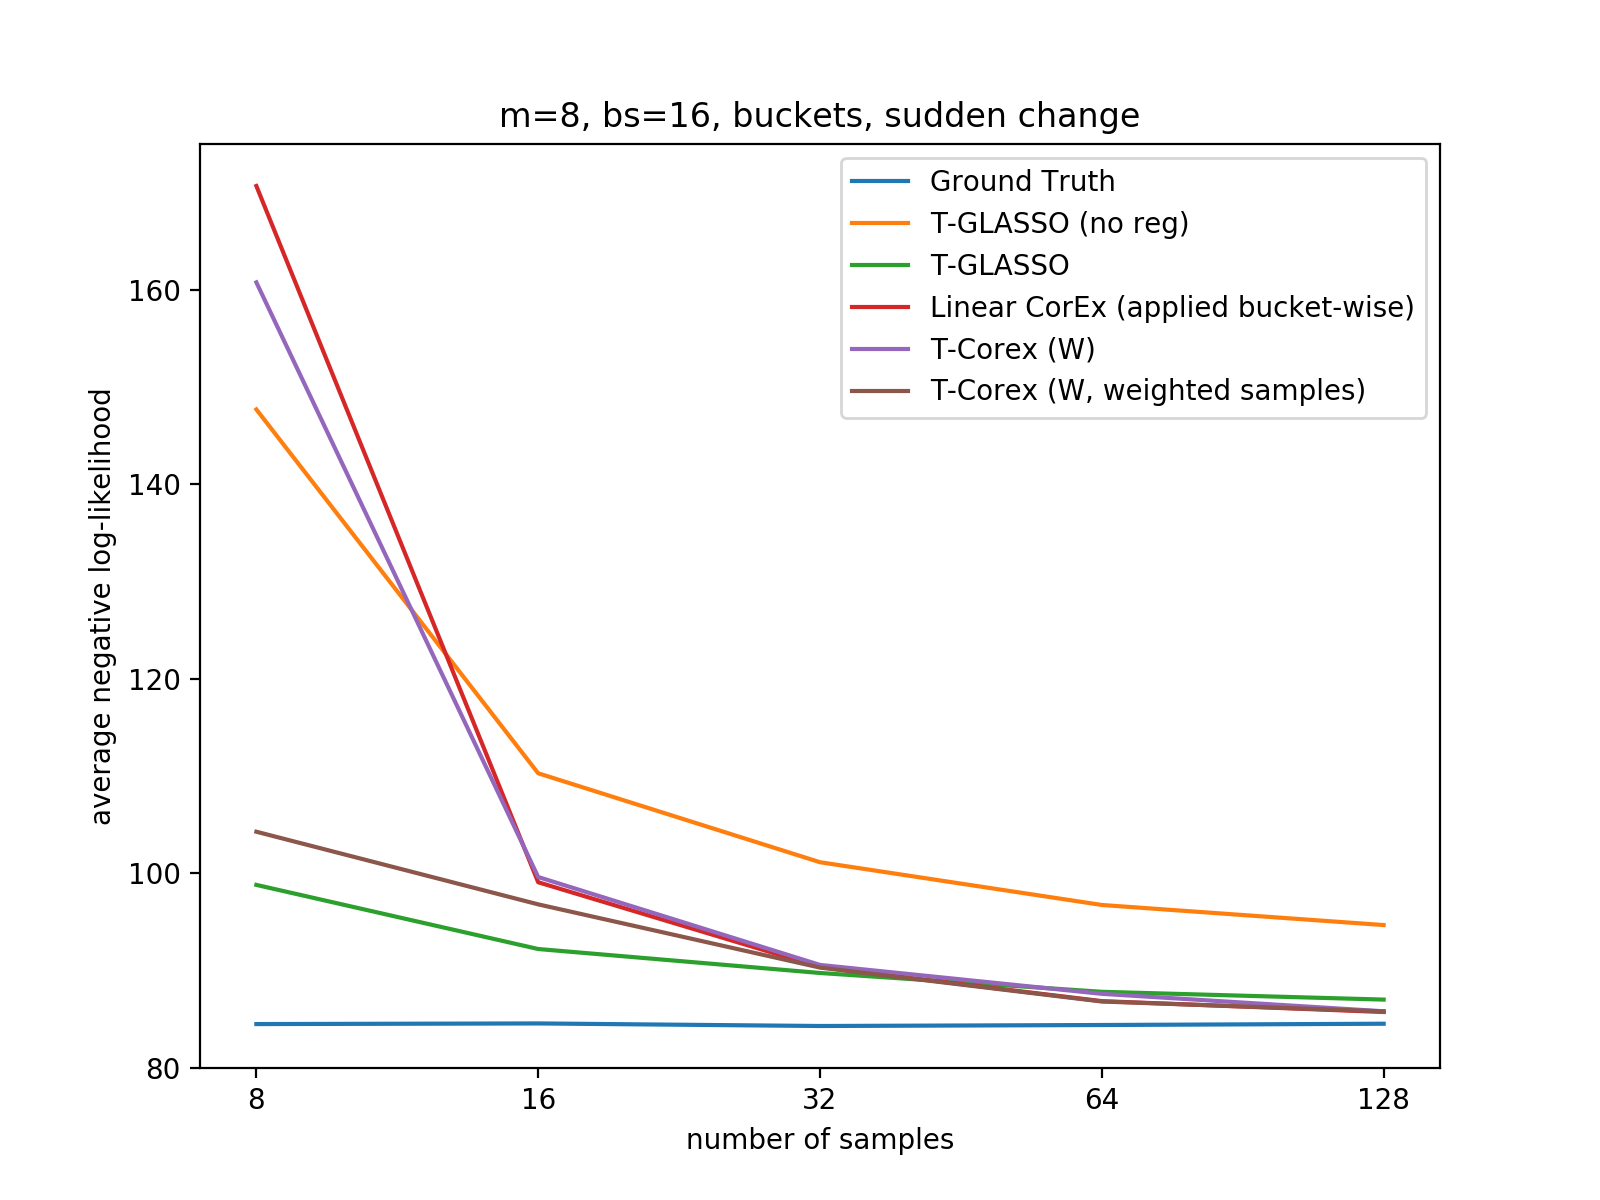

<IPython.core.display.Javascript object>


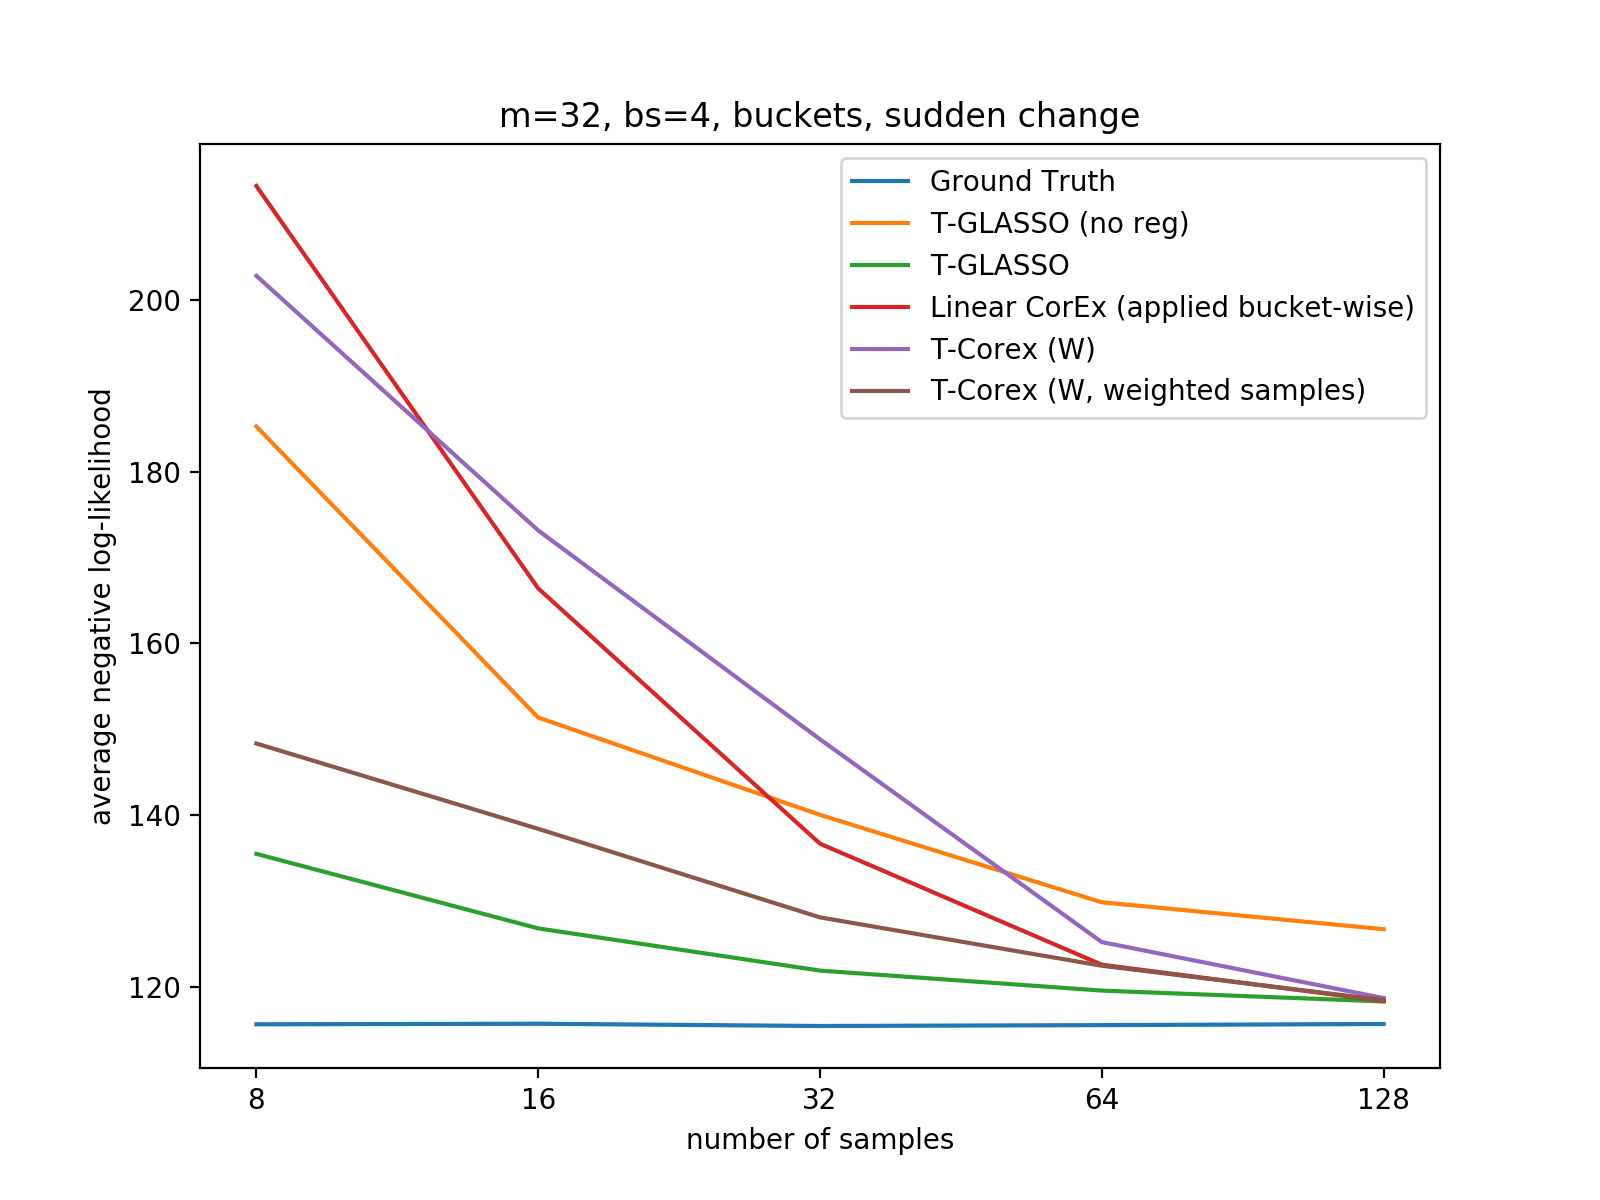

<IPython.core.display.Javascript object>


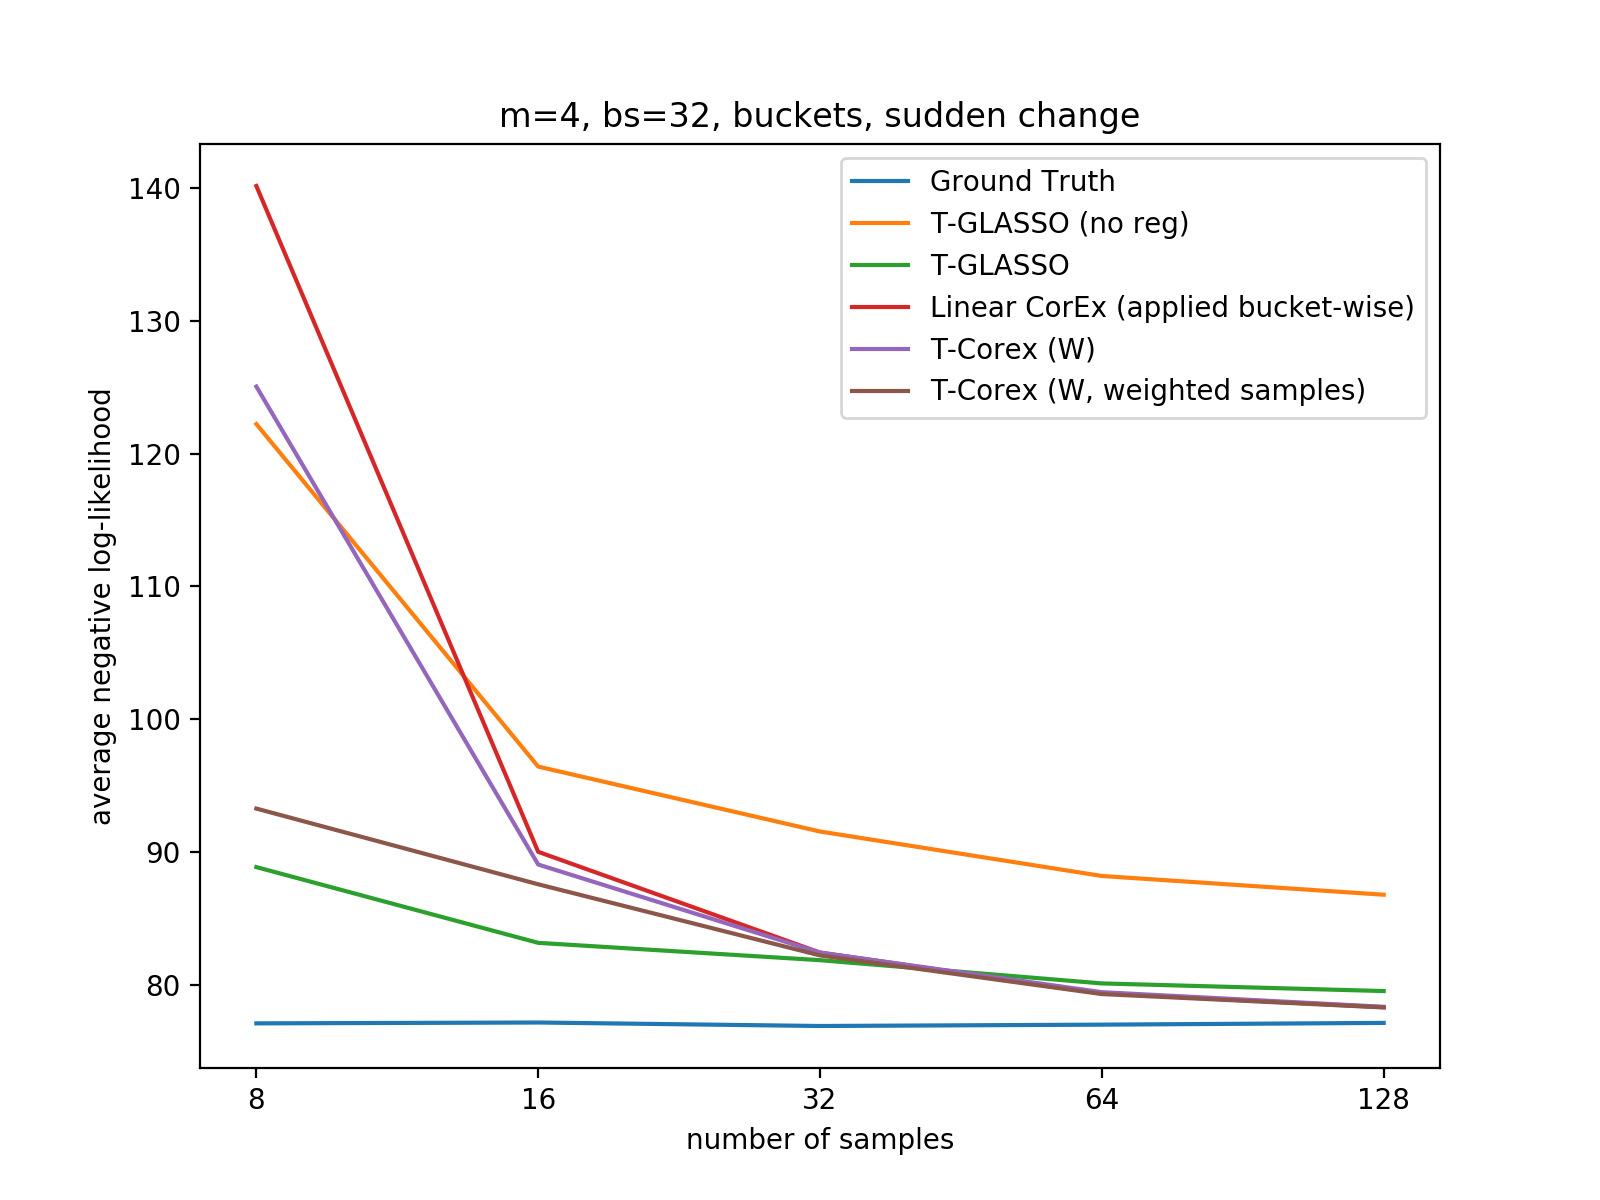

In [10]:
show_methods = [
    'Ground Truth',
    'T-GLASSO (no reg)',
#     'T-GLASSO',
    'T-GLASSO (more iters)',
    'Linear CorEx (applied bucket-wise)',
#     'Linear CorEx (applied on whole data)',
    'T-Corex (W)',
#     'T-Corex + priors (W, method 1)',
#     'T-Corex + priors (W, method 2)',
#     'T-Corex + priors (W, method 2, weighted samples)',
    'T-Corex (W, weighted samples)',
#     'T-Corex (W, weighted samples, no init)',
#     'Ledoit-Wolf',
#     'Factor Analysis',
#     'T-Corex (WWT)',
#     'T-Corex (MI)',
#     'T-Corex (Sigma)',
#     'Oracle approximating shrinkage',
#     'Diagonal',
#     'Graphical LASSO (sklearn)',
#     'PCA',
#     'T-GLASSO (more iters, no reg)'
]

name_map = {
    'T-GLASSO (more iters)': 'T-GLASSO'
}

visualize_case(syn_sudden_buckets_A1, 'm=8, bs=16, buckets, sudden change', show_methods, name_map)
visualize_case(syn_sudden_buckets_A2, 'm=32, bs=4, buckets, sudden change', show_methods, name_map)
visualize_case(syn_sudden_buckets_A3, 'm=4, bs=32, buckets, sudden change', show_methods, name_map)

## Sudden change, min_var=0.25, max_var=4.0, SNR=5.0

<IPython.core.display.Javascript object>


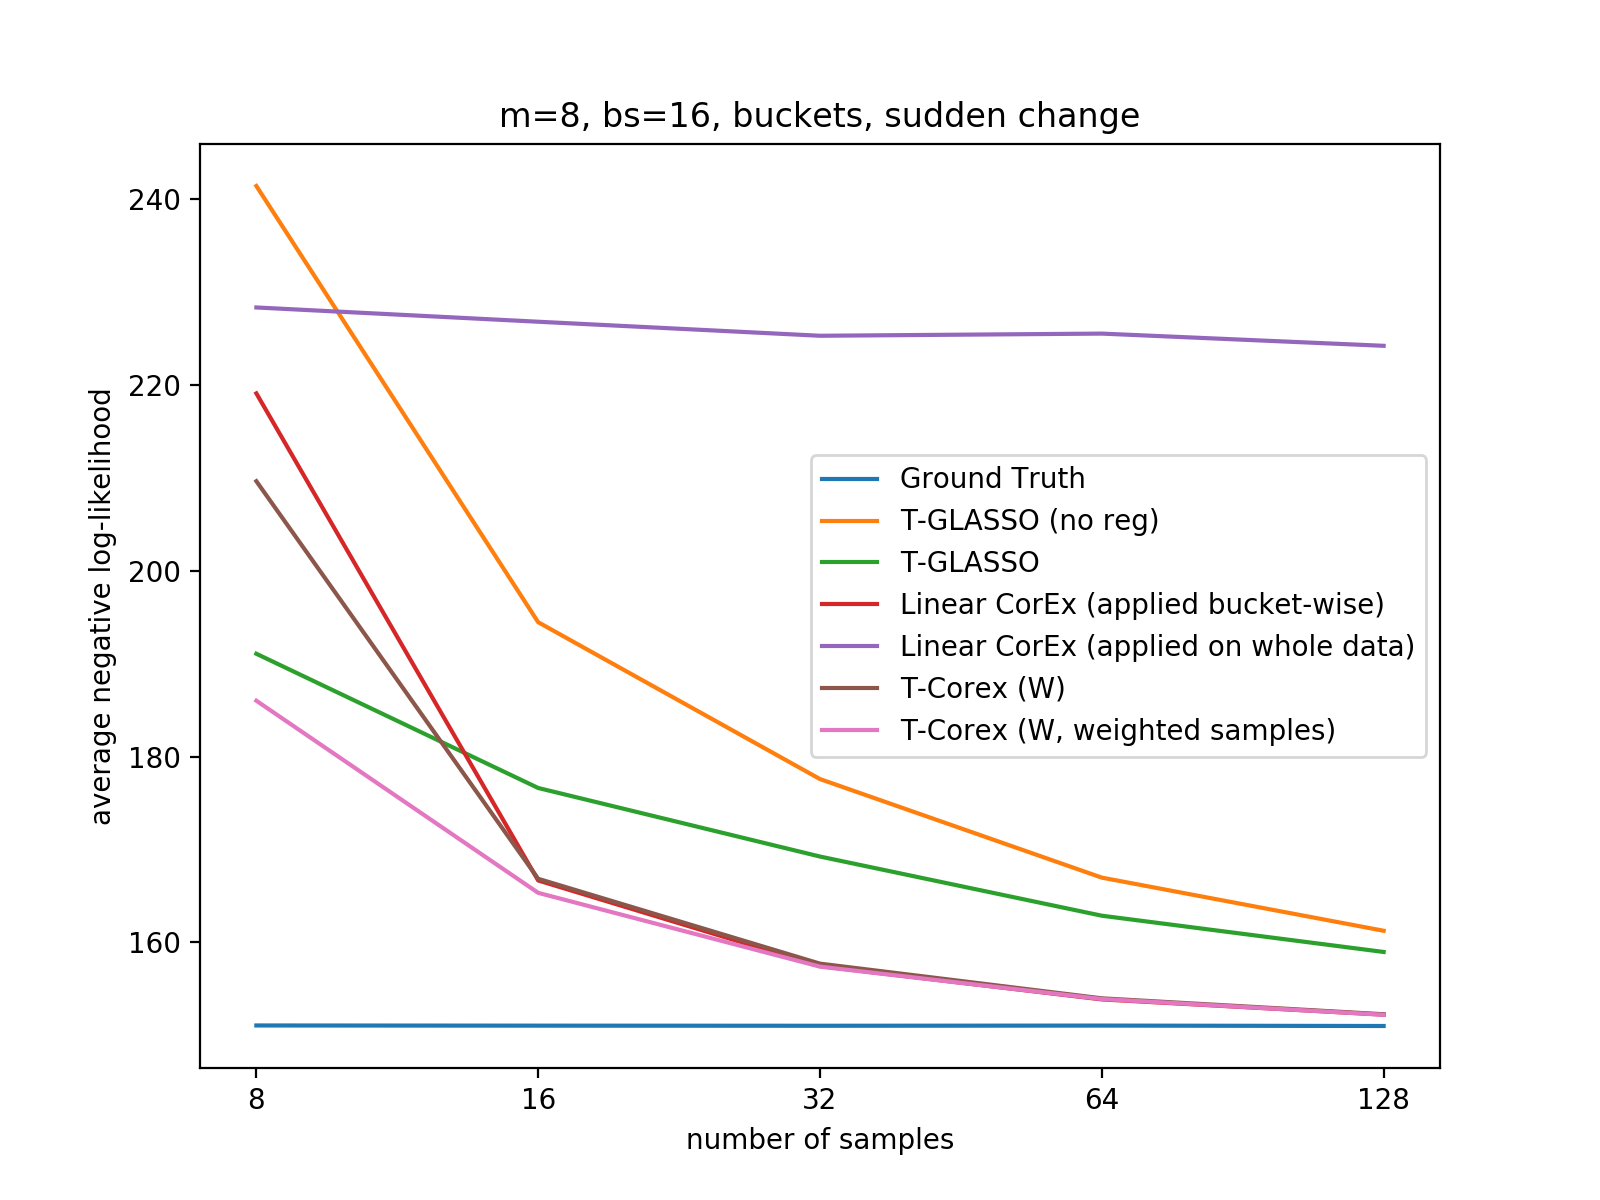

<IPython.core.display.Javascript object>


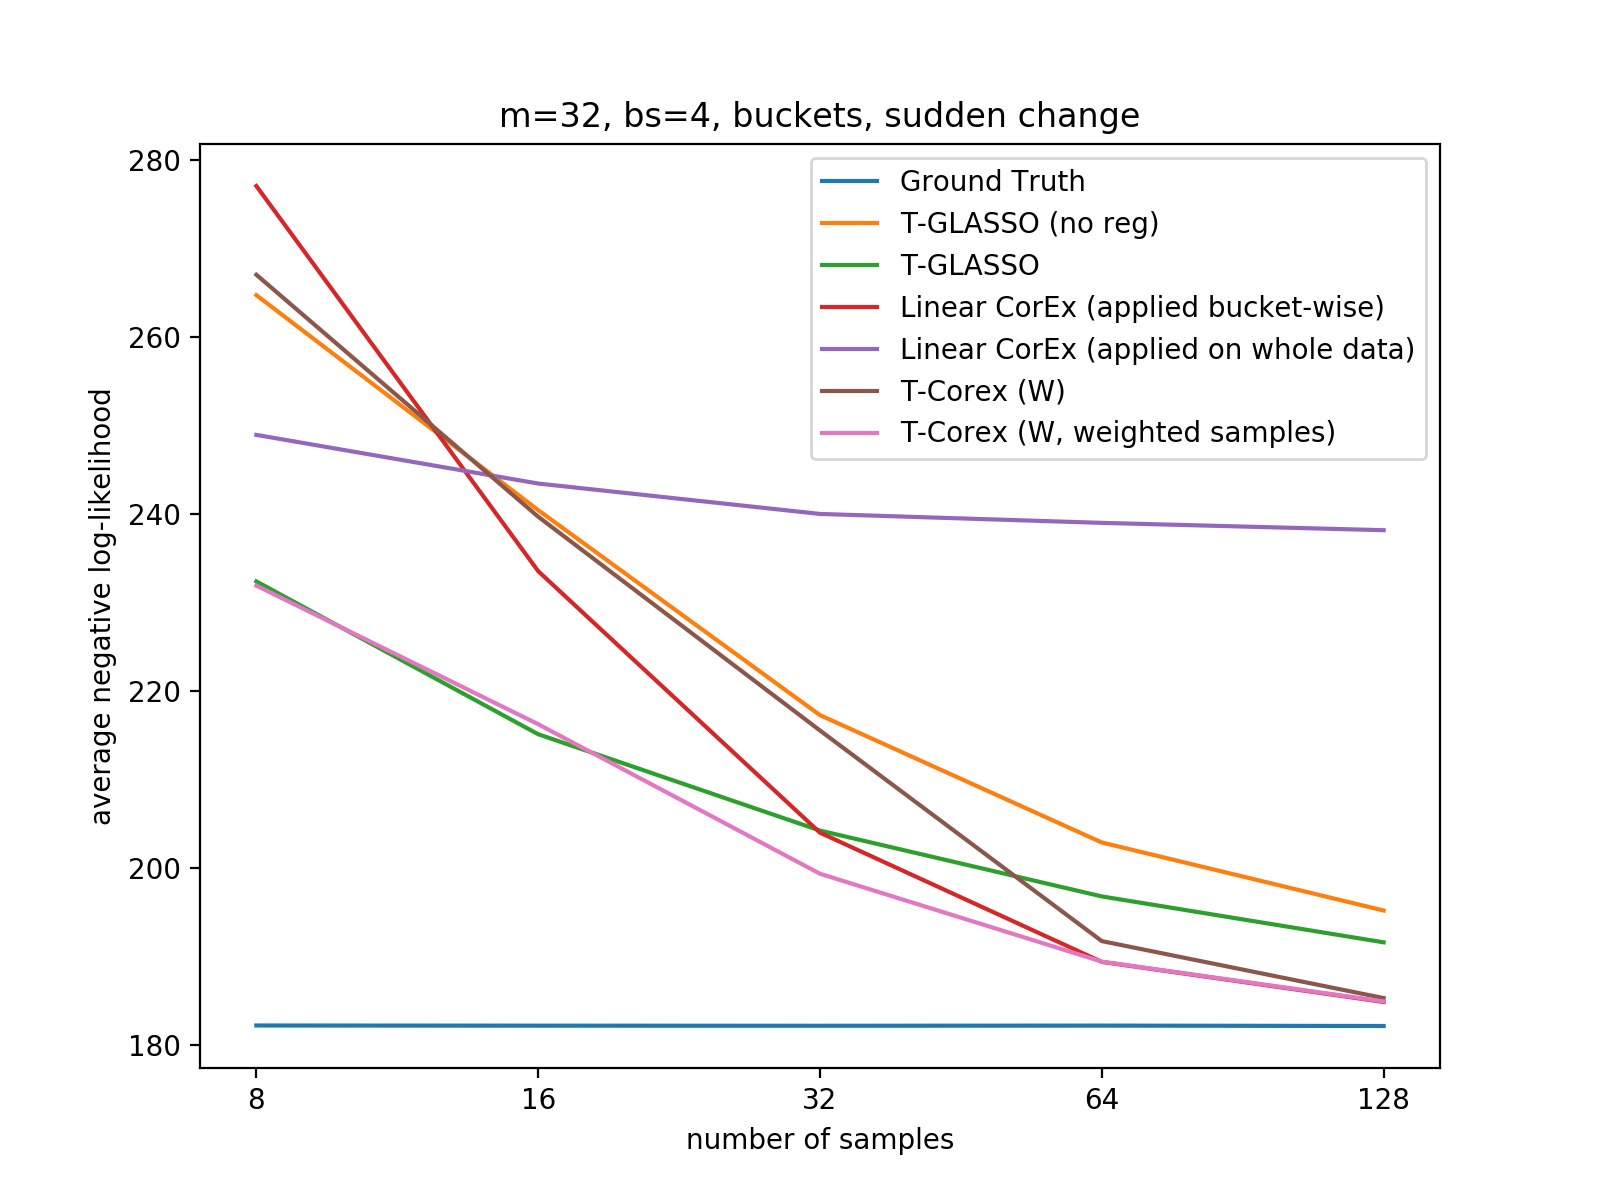

<IPython.core.display.Javascript object>


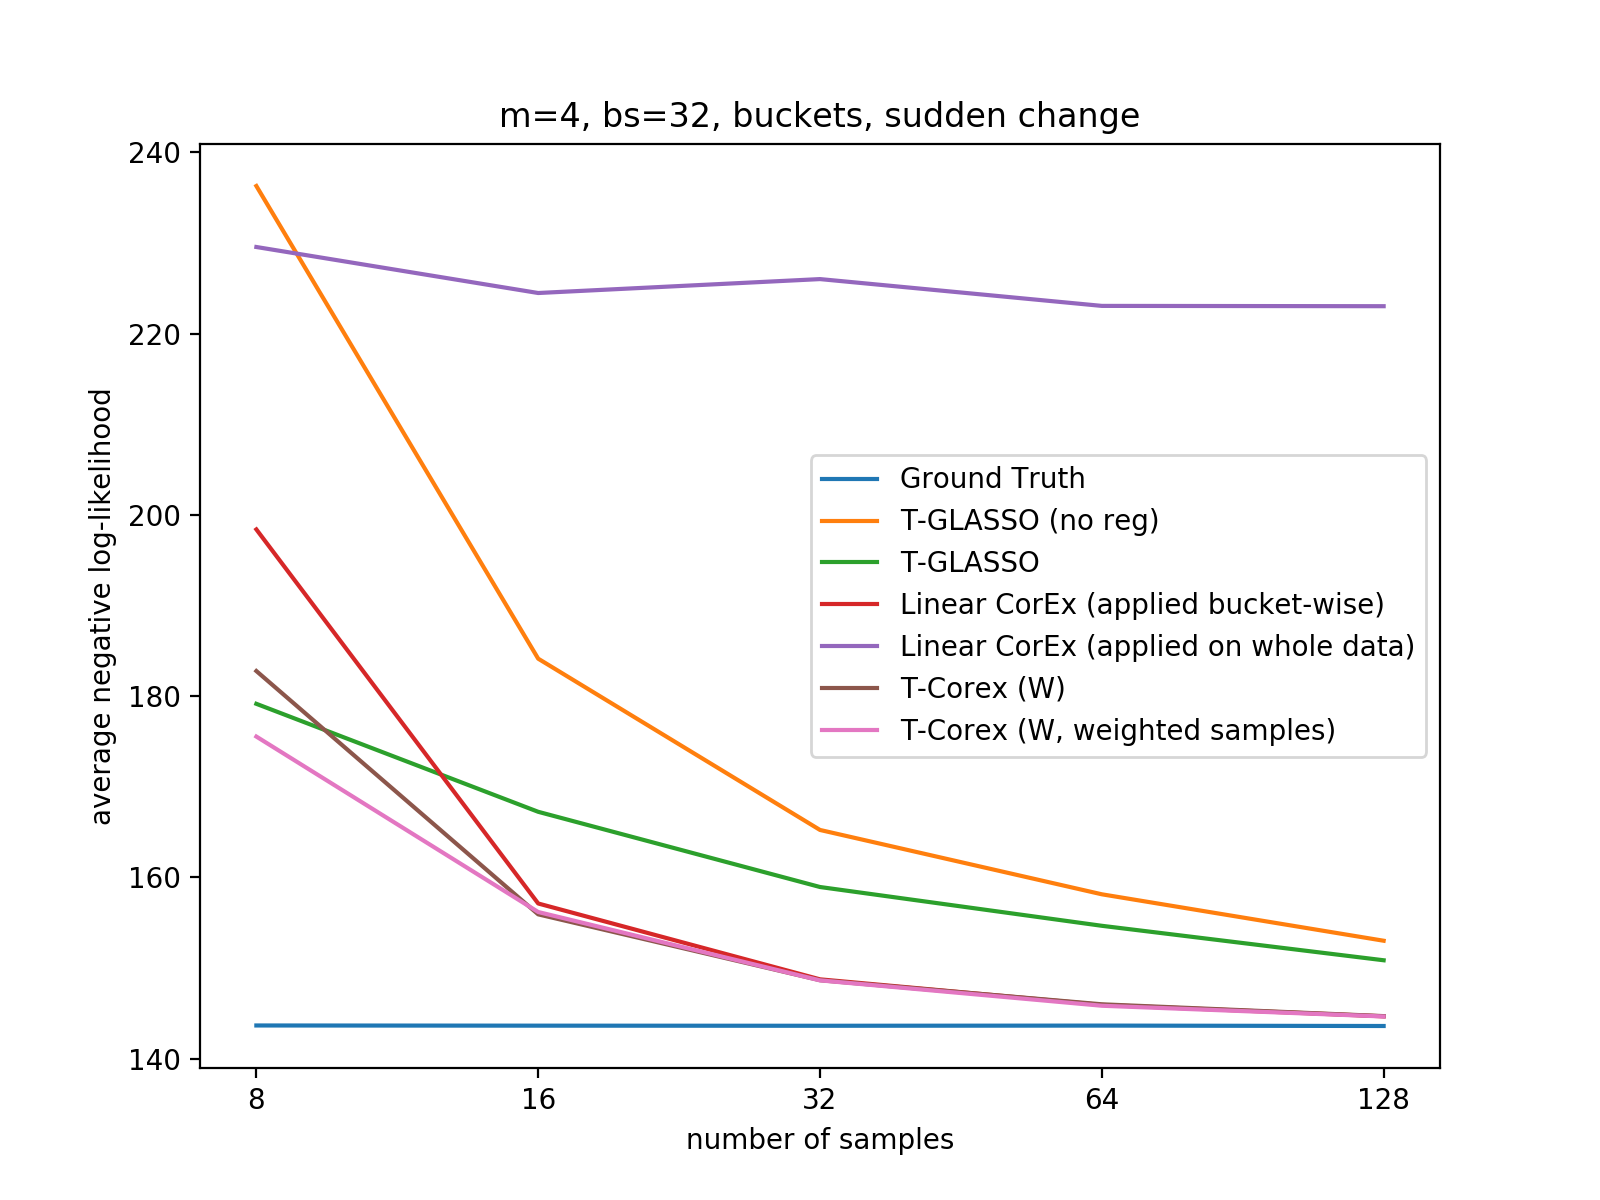

<IPython.core.display.Javascript object>


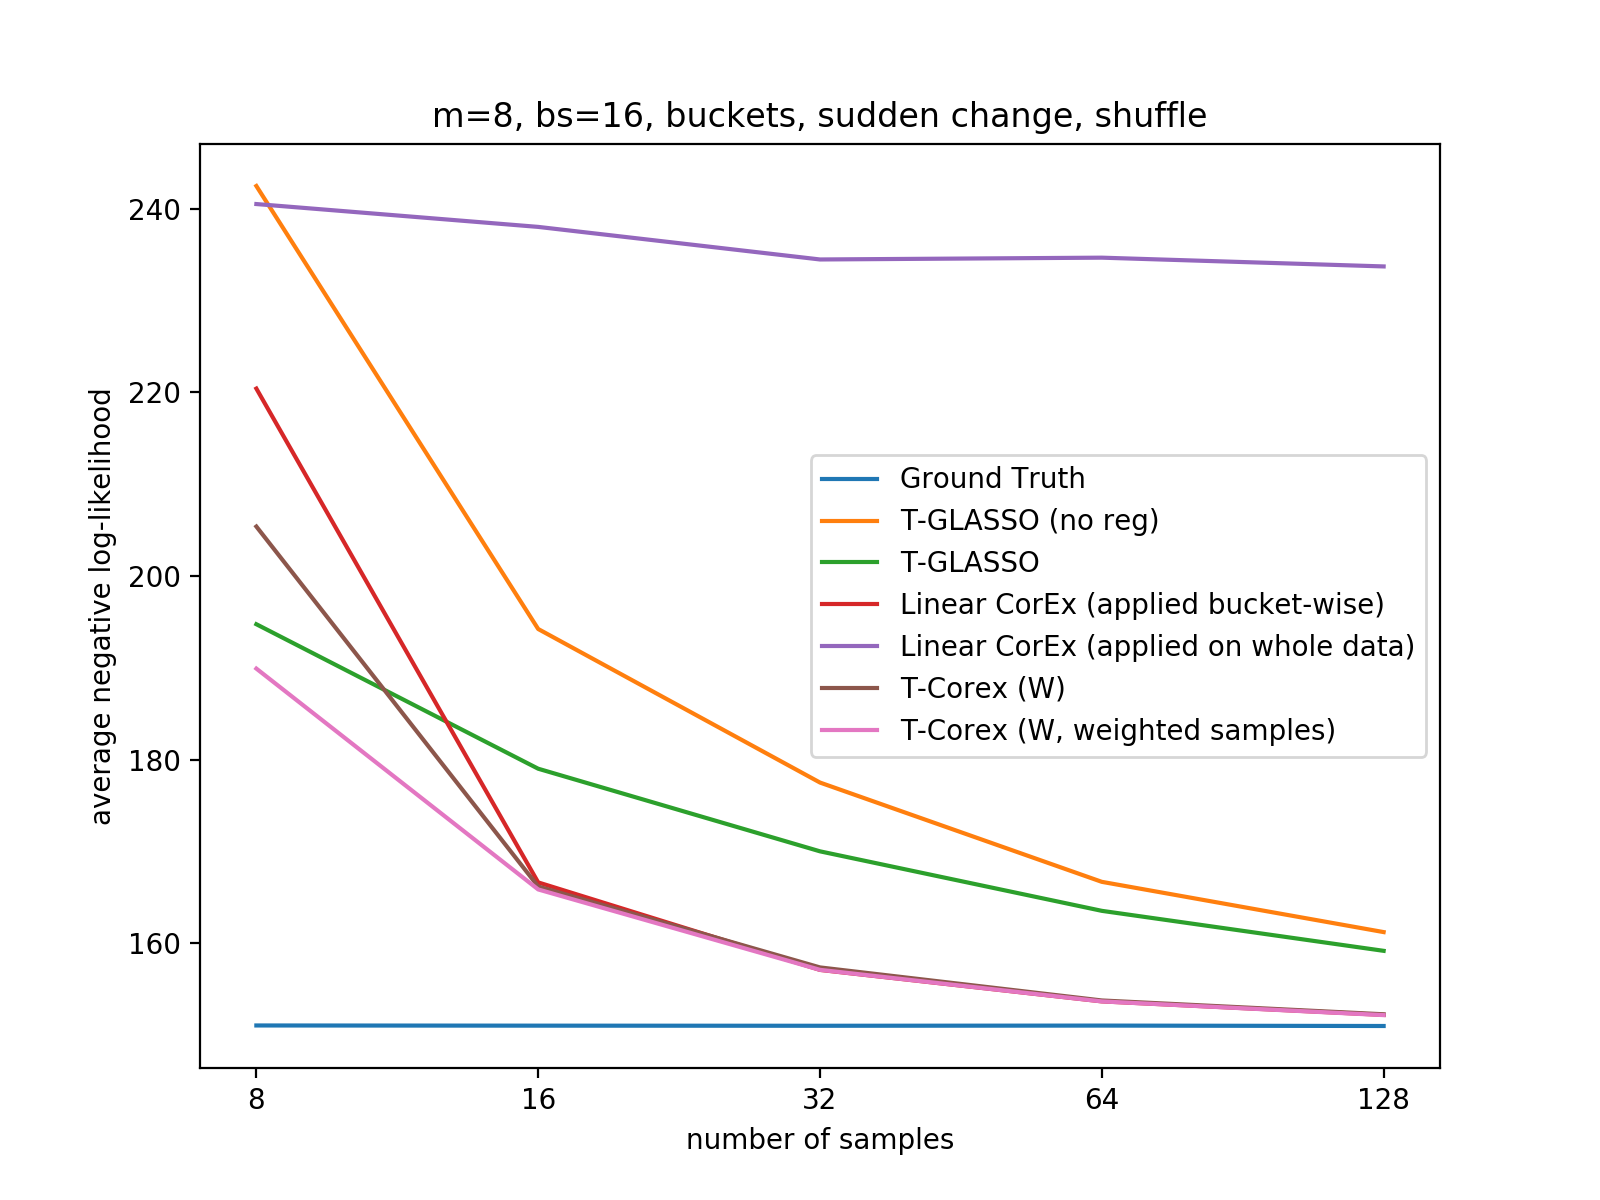

In [159]:
show_methods = [
    'Ground Truth',
    'T-GLASSO (no reg)',
    'T-GLASSO',
    'Linear CorEx (applied bucket-wise)',
    'Linear CorEx (applied on whole data)',
    'T-Corex (W)',
#     'T-Corex + priors (W, method 1)',
#     'T-Corex + priors (W, method 2)',
#     'T-Corex + priors (W, method 2, weighted samples)',
    'T-Corex (W, weighted samples)',
#     'T-Corex (W, weighted samples, no init)',
#     'T-Corex (W, weighted samples, no reg)',
#     'Ledoit-Wolf',
#     'Factor Analysis',
#     'T-Corex (WWT)',
#     'T-Corex (MI)',
#     'T-Corex (Sigma)',
#     'Oracle approximating shrinkage',
#     'Diagonal',
#     'Graphical LASSO (sklearn)',
#     'PCA',
#     'T-GLASSO (more iters, no reg)'
]

name_map = {
}

visualize_case(syn_sudden_buckets_A1_new, 'm=8, bs=16, buckets, sudden change', show_methods, name_map, sizes=[8,16,32,64, 128])
visualize_case(syn_sudden_buckets_A2_new, 'm=32, bs=4, buckets, sudden change', show_methods, name_map, sizes=[8,16,32,64, 128])
visualize_case(syn_sudden_buckets_A3_new, 'm=4, bs=32, buckets, sudden change', show_methods, name_map, sizes=[8,16,32,64, 128])
visualize_case(syn_sudden_buckets_A1_new_shuffle, 'm=8, bs=16, buckets, sudden change, shuffle', show_methods, name_map, sizes=[8,16,32,64, 128])


#### print result table

In [183]:
show_methods = [
    'Ground Truth',
    'Diagonal',
    'Ledoit-Wolf',
    'Oracle approximating shrinkage',
    'Factor Analysis',
    'PCA',
    'T-GLASSO (no reg)',
    'T-GLASSO',
#     'T-GLASSO (more iters)',
    'Linear CorEx (applied bucket-wise)',
#     'Linear CorEx (applied on whole data)',
    'T-Corex (W)',
#     'T-Corex + priors (W, method 1)',
#     'T-Corex + priors (W, method 2)',
#     'T-Corex + priors (W, method 2, weighted samples)',
    'T-Corex (W, weighted samples)',
#     'T-Corex (W, weighted samples, no init)',
#     'T-Corex (WWT)',
#     'T-Corex (MI)',
#     'T-Corex (Sigma)',
#     'Graphical LASSO (sklearn)',
#     'T-GLASSO (more iters, no reg)'
]

name_map = {
    'Factor Analysis': 'FA',
    'Oracle approximating shrinkage': 'OAS',
    'Ledoit-Wolf': 'LW',
    'T-GLASSO (more iters)': 'T-GLASSO',
    'Linear CorEx (applied bucket-wise)': 'Linear CorEx',
    'T-Corex (W)': 'T-CorEx-base',
    'T-Corex (W, weighted samples)': 'T-CorEx',
    'T-GLASSO (no reg)': 'GLASSO'
}

print_result_table(syn_sudden_buckets_A1_new, show_methods, name_map)   
print_result_table(syn_sudden_buckets_A2_new, show_methods, name_map)   

reading m = 8, bs = 16, train_cnt = 8
reading m = 8, bs = 16, train_cnt = 16
reading m = 8, bs = 16, train_cnt = 32
reading m = 8, bs = 16, train_cnt = 64
reading m = 8, bs = 16, train_cnt = 128


\begin{table}
\begin{center}
\begin{tabular}{lccccc}
\toprule
Մեթոդ &             $s=8$              &             $s=16$             &             $s=32$             &             $s=64$             &            $s=128$             \\
\midrule
Ground Truth & 151.07 & 151.05 & 151.04 & 151.06 & 151.02 \\
Diagonal   & 265.06 & 254.36 & 250.83 & 249.09 & 248.33 \\
LW         & 255.82 & 229.94 & 209.78 & 194.74 & 182.18 \\
OAS        & 256.00 & 231.54 & 210.54 & 194.98 & 182.26 \\
FA         & - & 473.27 & 191.28 & 164.47 & 156.34 \\
PCA        & - & 259.10 & 228.94 & 203.19 & 193.58 \\
GLASSO     & 241.37 & 194.45 & 177.58 & 166.98 & 161.26 \\
T-GLASSO   & 191.06 & 176.62 & 169.24 & 162.88 & 158.98 \\
Linear CorEx & 219.06 & 166.67 & \textbf{157.46} & \textbf{153.88} & \textbf{152.24} \\
T-CorE

## Sudden change; new; min_var=1, max_var=1

<IPython.core.display.Javascript object>


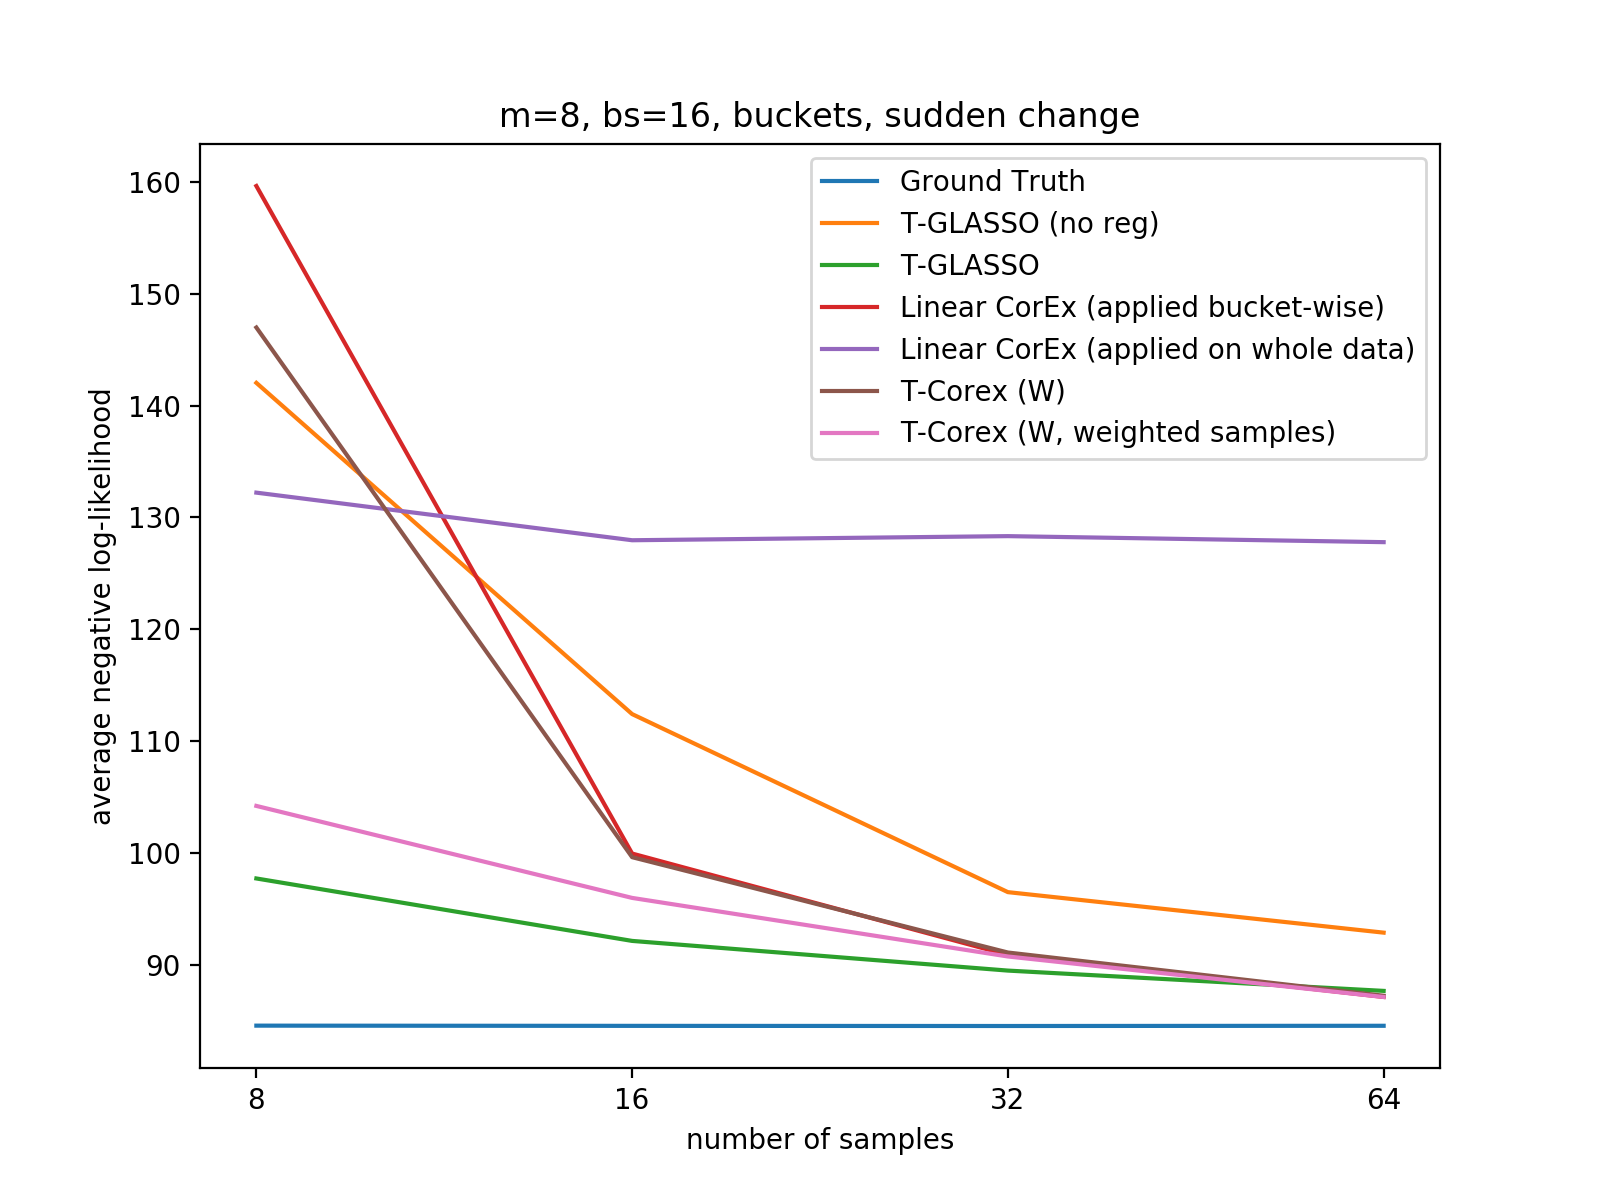

<IPython.core.display.Javascript object>


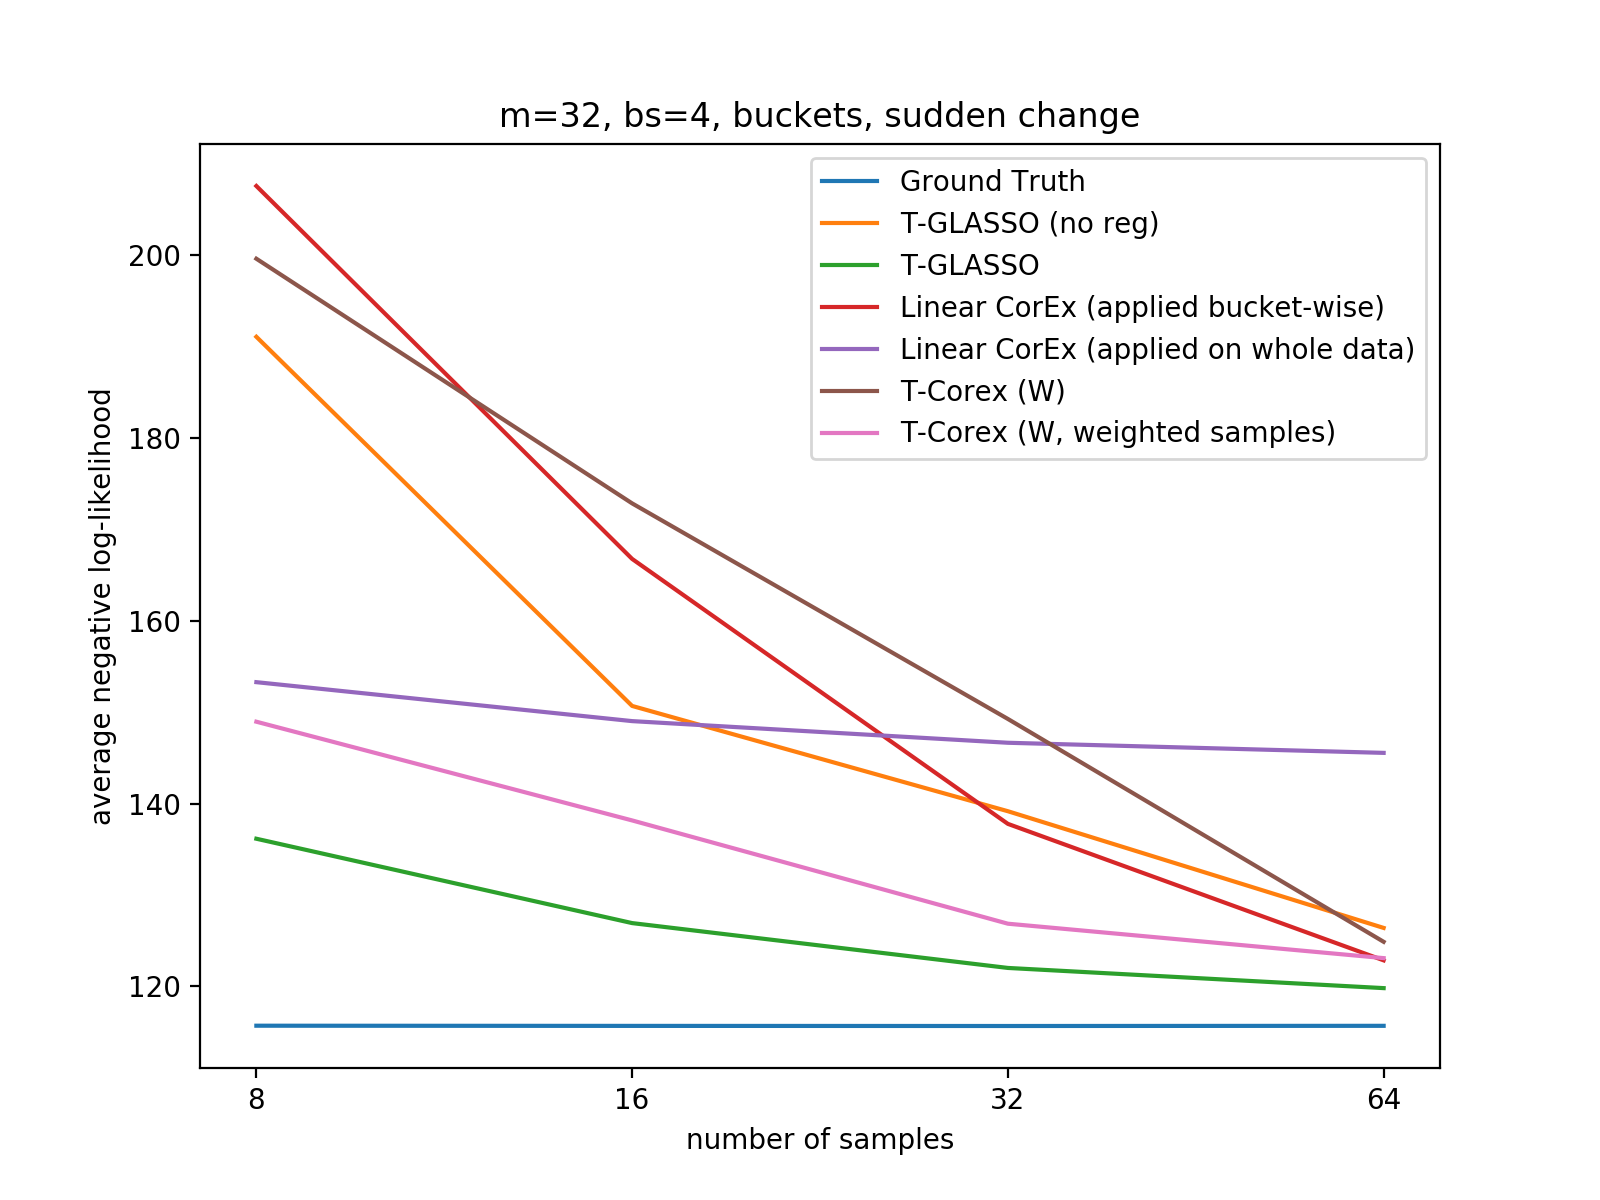

<IPython.core.display.Javascript object>


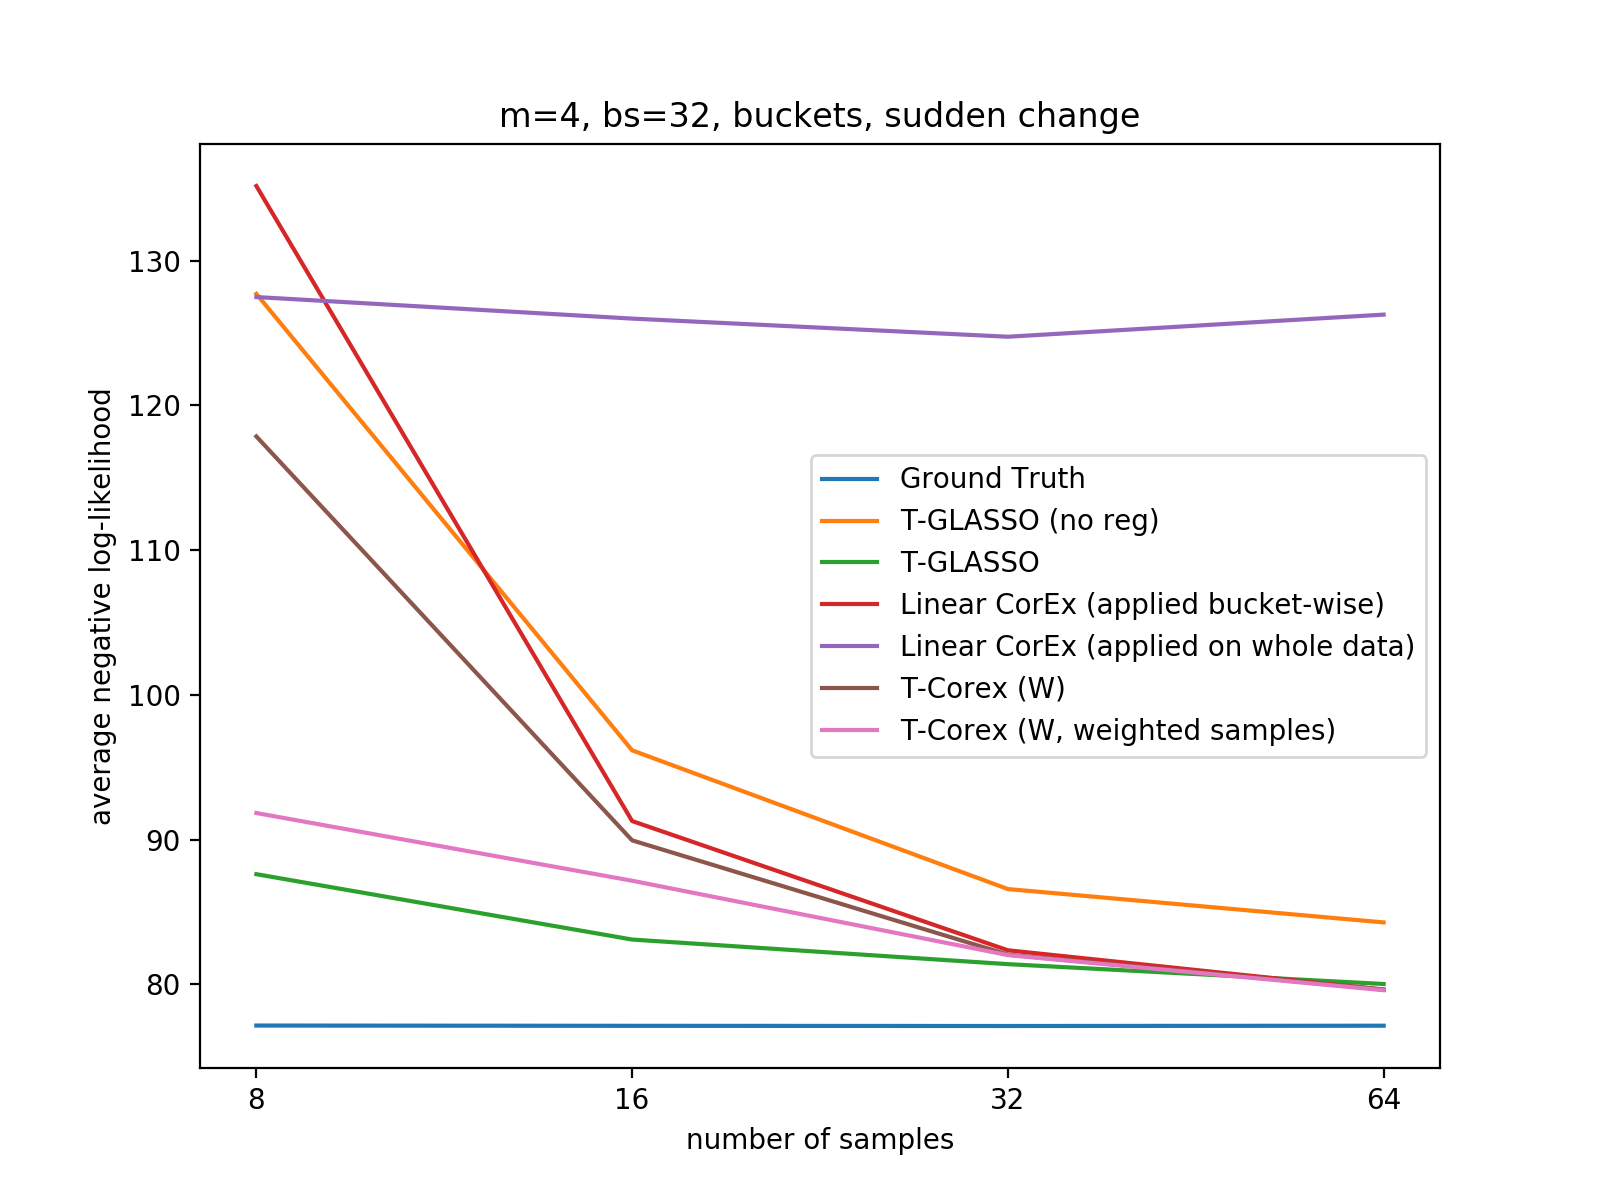

<IPython.core.display.Javascript object>


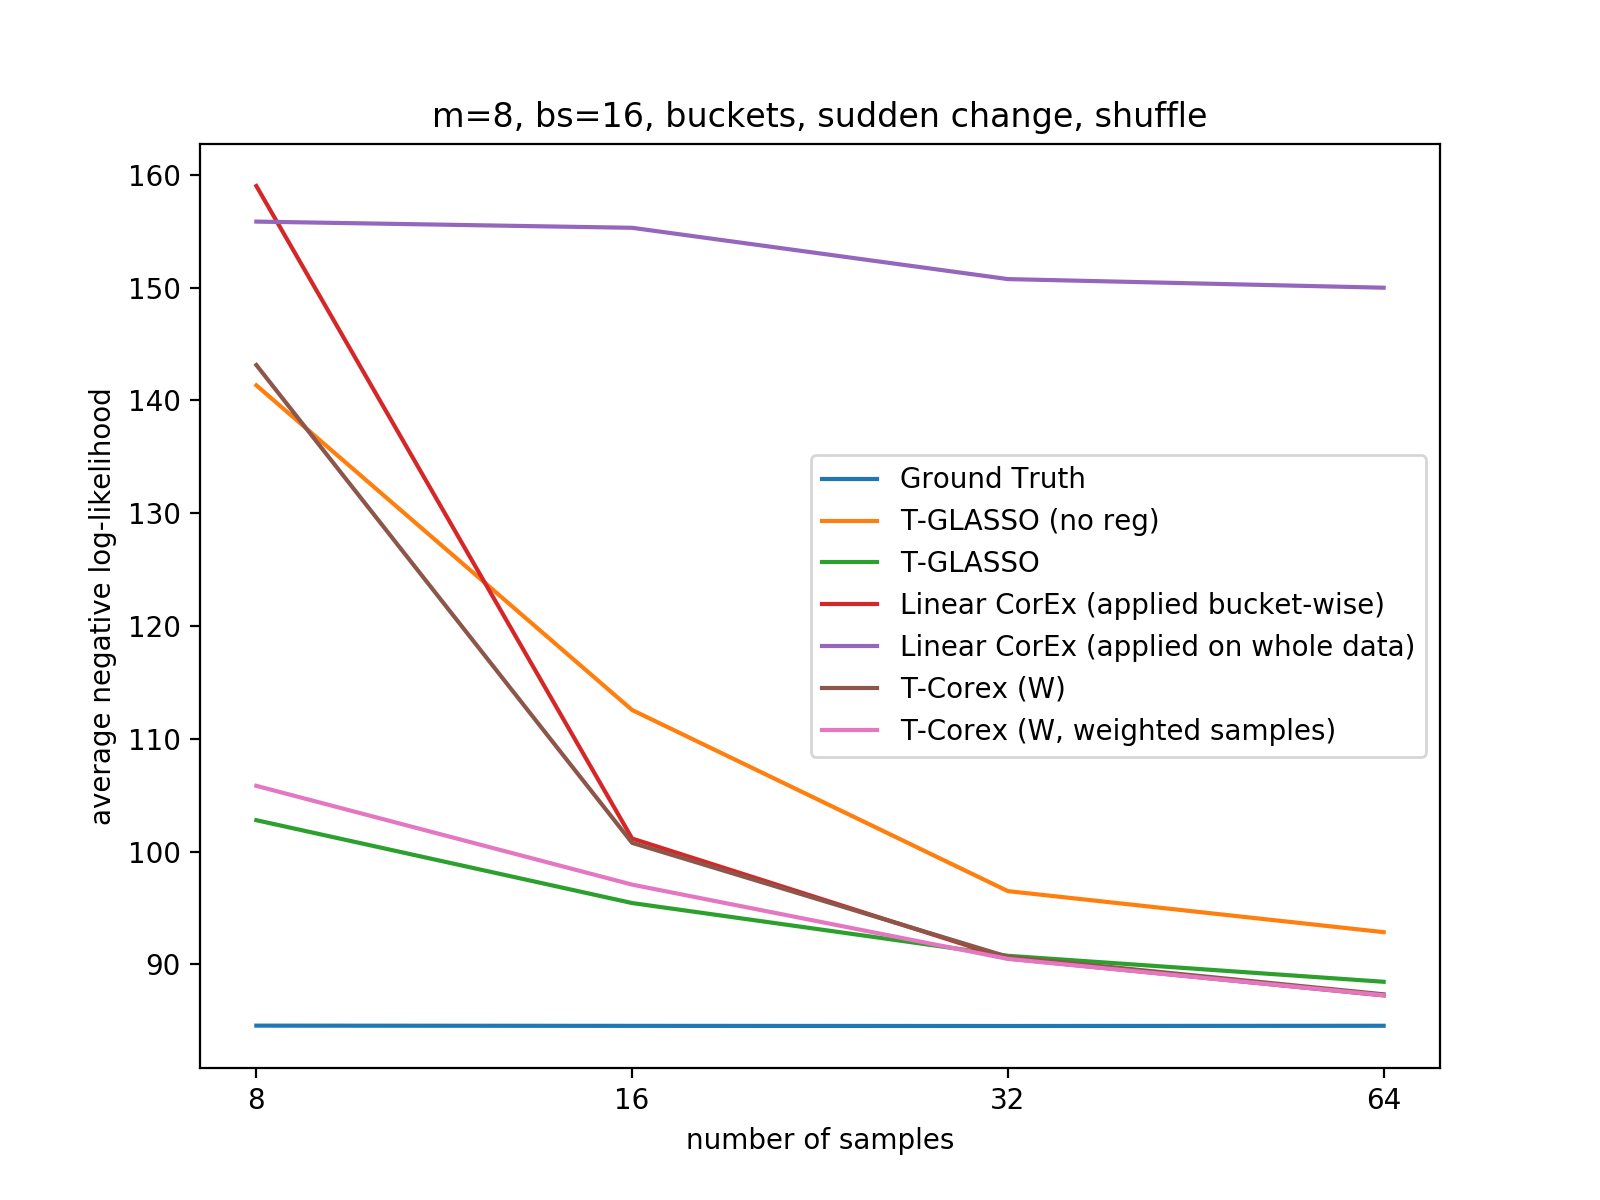

In [160]:
show_methods = [
    'Ground Truth',
    'T-GLASSO (no reg)',
    'T-GLASSO',
    'Linear CorEx (applied bucket-wise)',
    'Linear CorEx (applied on whole data)',
    'T-Corex (W)',
#     'T-Corex + priors (W, method 1)',
#     'T-Corex + priors (W, method 2)',
#     'T-Corex + priors (W, method 2, weighted samples)',
    'T-Corex (W, weighted samples)',
#     'T-Corex (W, weighted samples, no init)',
#     'T-Corex (W, weighted samples, no reg)',
#     'Ledoit-Wolf',
#     'Factor Analysis',
#     'T-Corex (WWT)',
#     'T-Corex (MI)',
#     'T-Corex (Sigma)',
#     'Oracle approximating shrinkage',
#     'Diagonal',
#     'Graphical LASSO (sklearn)',
#     'PCA',
#     'T-GLASSO (more iters, no reg)'
]

name_map = {
}

visualize_case(syn_sudden_buckets_A1_new_unit_var, 'm=8, bs=16, buckets, sudden change', show_methods, name_map, sizes=[8,16,32,64])
visualize_case(syn_sudden_buckets_A2_new_unit_var, 'm=32, bs=4, buckets, sudden change', show_methods, name_map, sizes=[8,16,32,64])
visualize_case(syn_sudden_buckets_A3_new_unit_var, 'm=4, bs=32, buckets, sudden change', show_methods, name_map, sizes=[8,16,32,64])
visualize_case(syn_sudden_buckets_A1_new_shuffle_unit_var, 'm=8, bs=16, buckets, sudden change, shuffle', show_methods, name_map, sizes=[8,16,32,64])


<IPython.core.display.Javascript object>


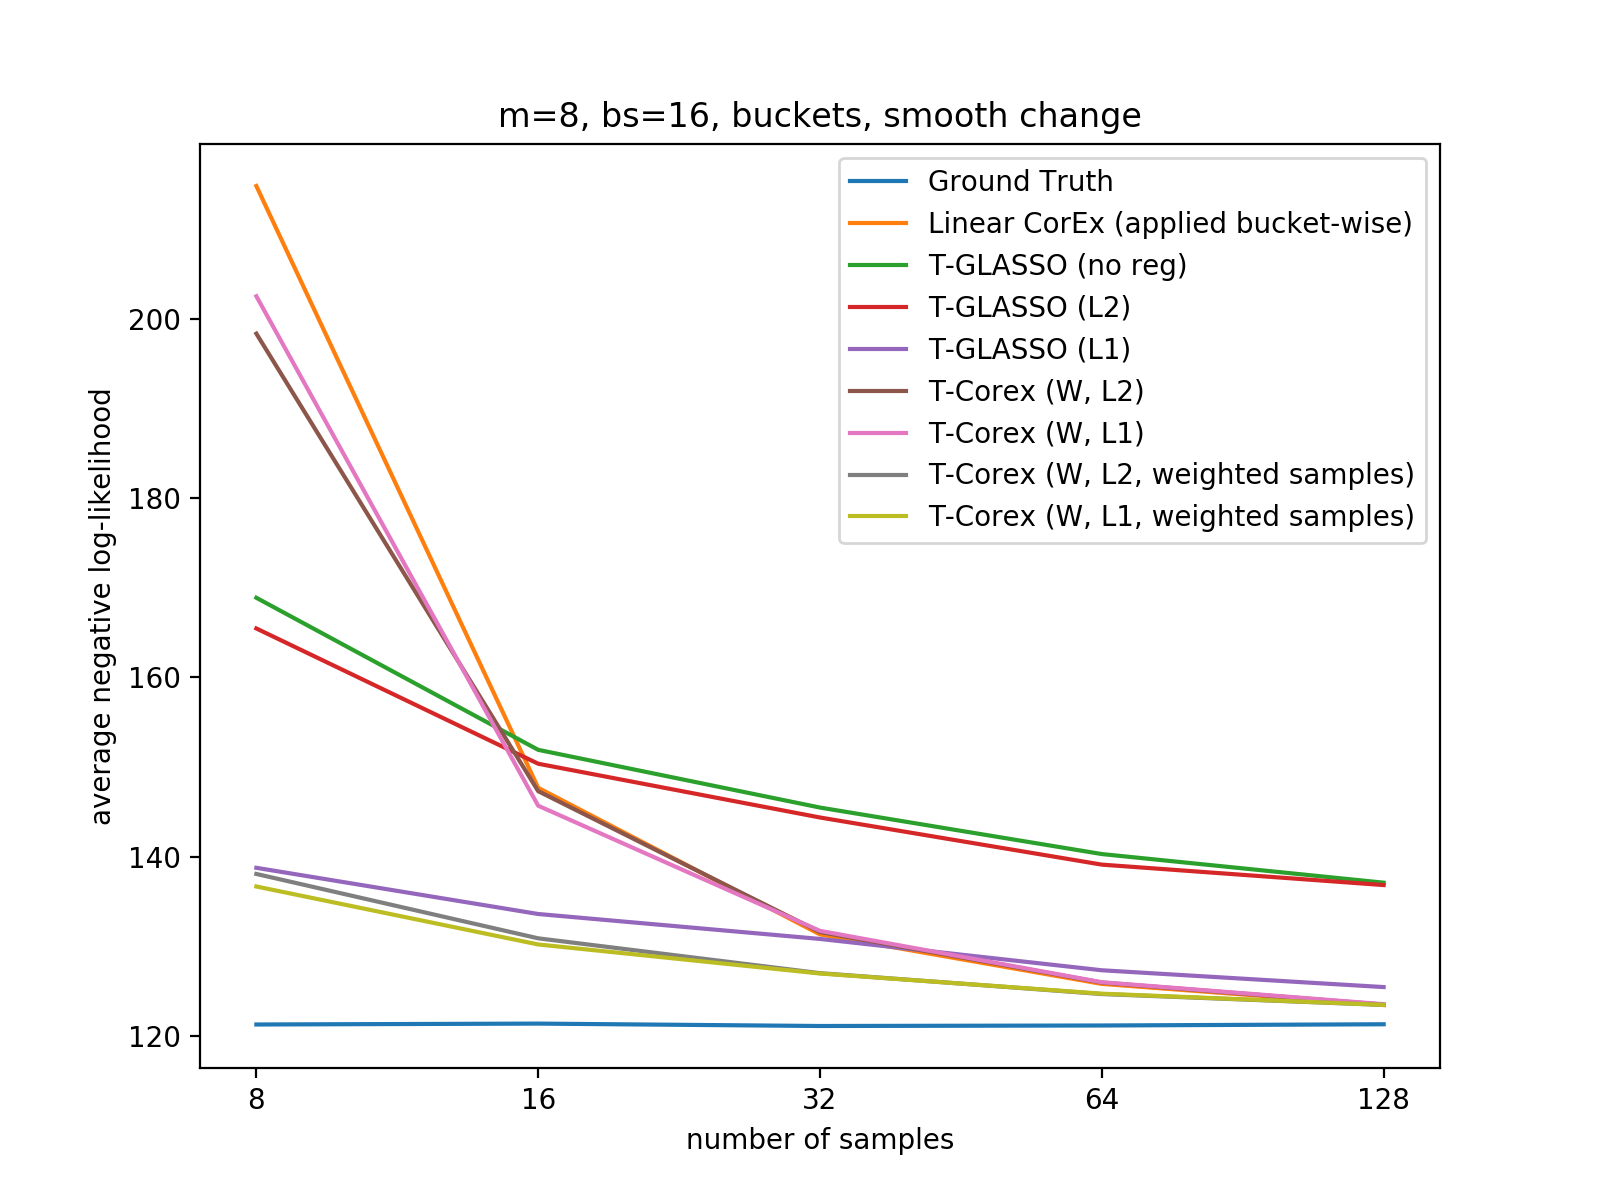

<IPython.core.display.Javascript object>


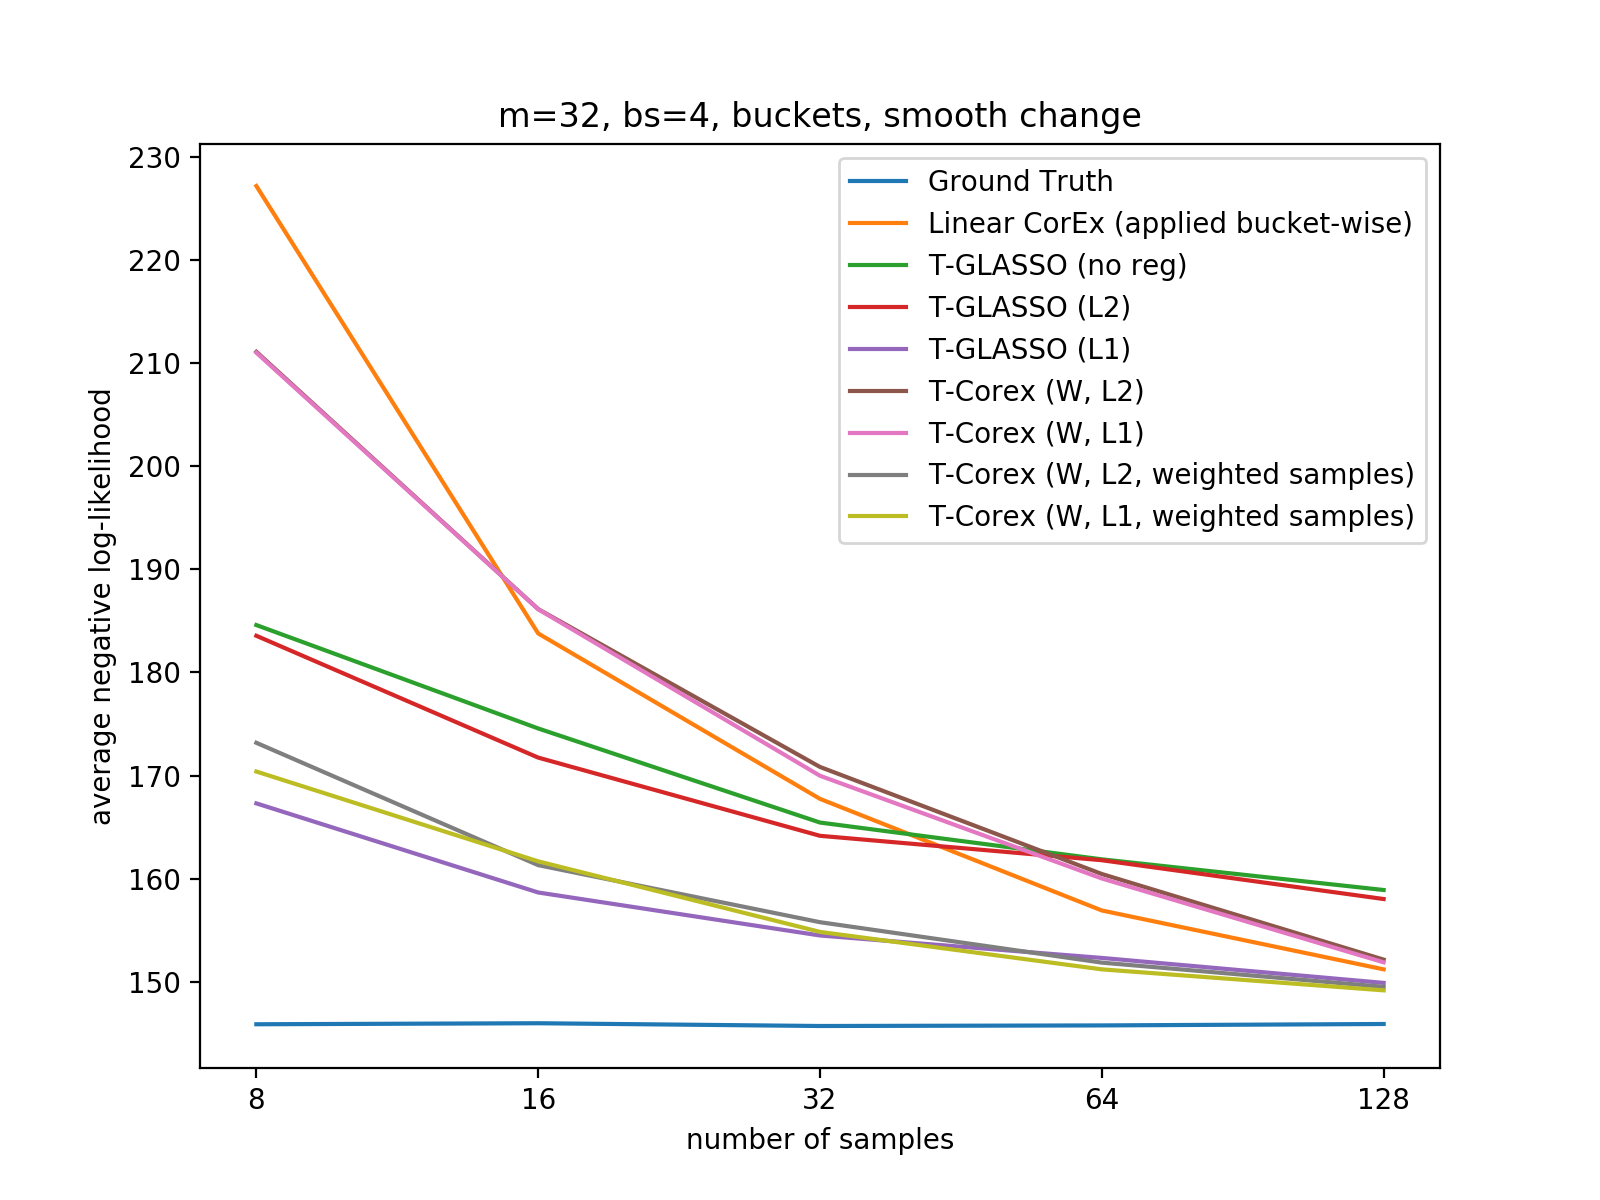

<IPython.core.display.Javascript object>


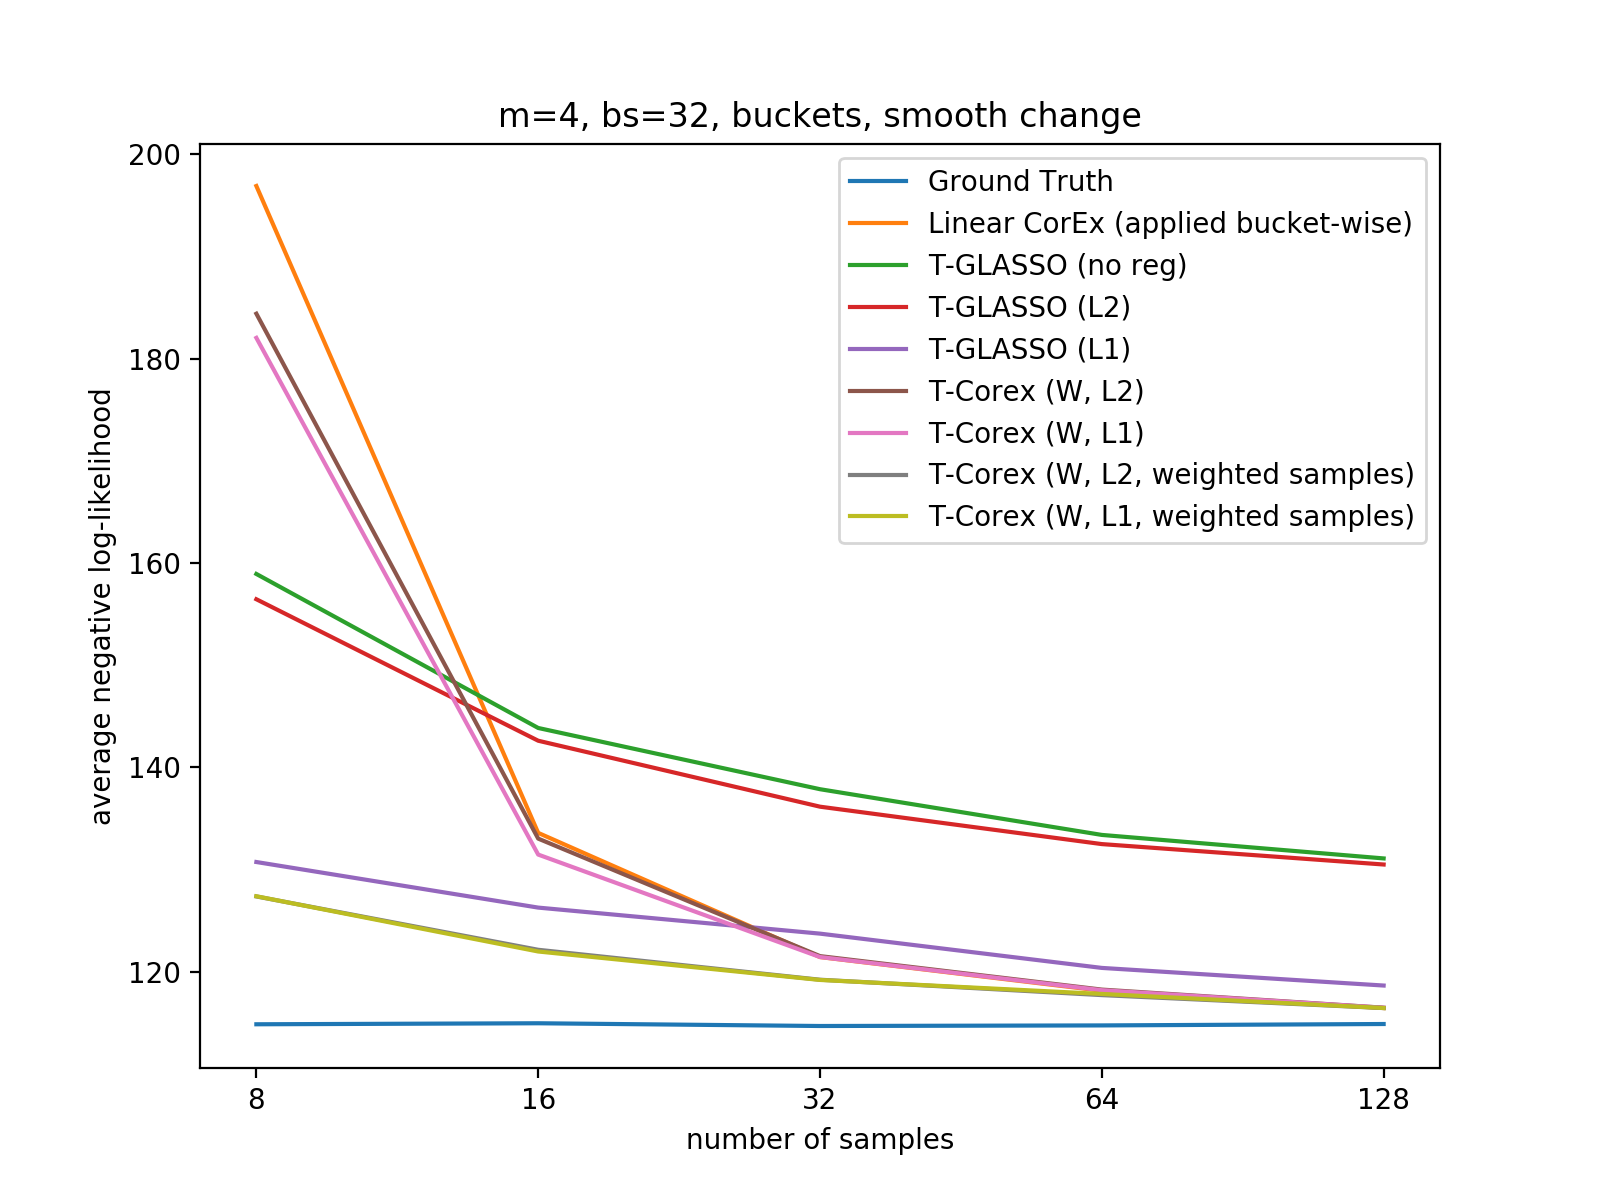

In [9]:
show_methods=[
    'Ground Truth',
    'Linear CorEx (applied bucket-wise)',
#     'Linear CorEx (applied on whole data)',
    'T-GLASSO (no reg)',
    'T-GLASSO (L2)',
    'T-GLASSO (L1)',
    'T-Corex (W, L2)',
    'T-Corex (W, L1)',
    'T-Corex (W, L2, weighted samples)',
    'T-Corex (W, L1, weighted samples)',
#     'PCA',
#     'Graphical LASSO (sklearn)',
#     'Diagonal',
#     'Oracle approximating shrinkage',
#     'Factor Analysis',
#     'Ledoit-Wolf'
]

visualize_case(syn_smooth_buckets_A1, 'm=8, bs=16, buckets, smooth change', show_methods)
visualize_case(syn_smooth_buckets_A2, 'm=32, bs=4, buckets, smooth change', show_methods)
visualize_case(syn_smooth_buckets_A3, 'm=4, bs=32, buckets, smooth change', show_methods)

<IPython.core.display.Javascript object>


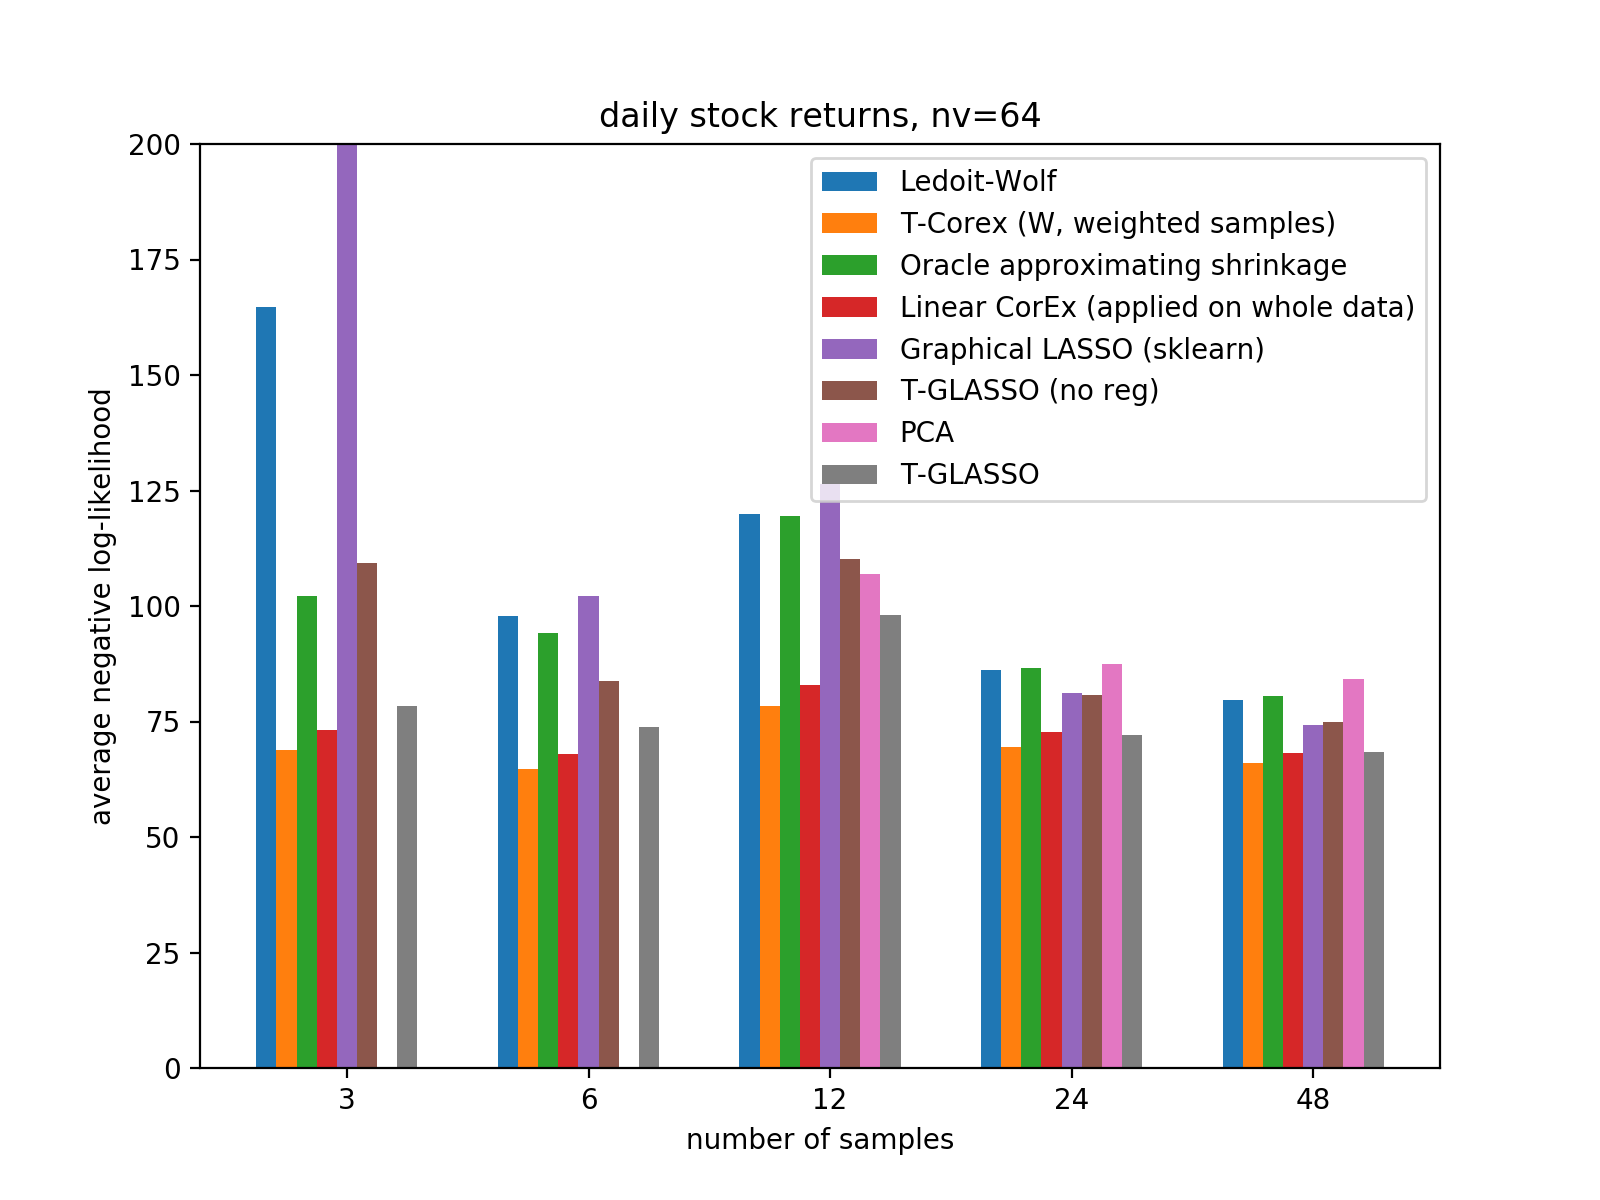

<IPython.core.display.Javascript object>


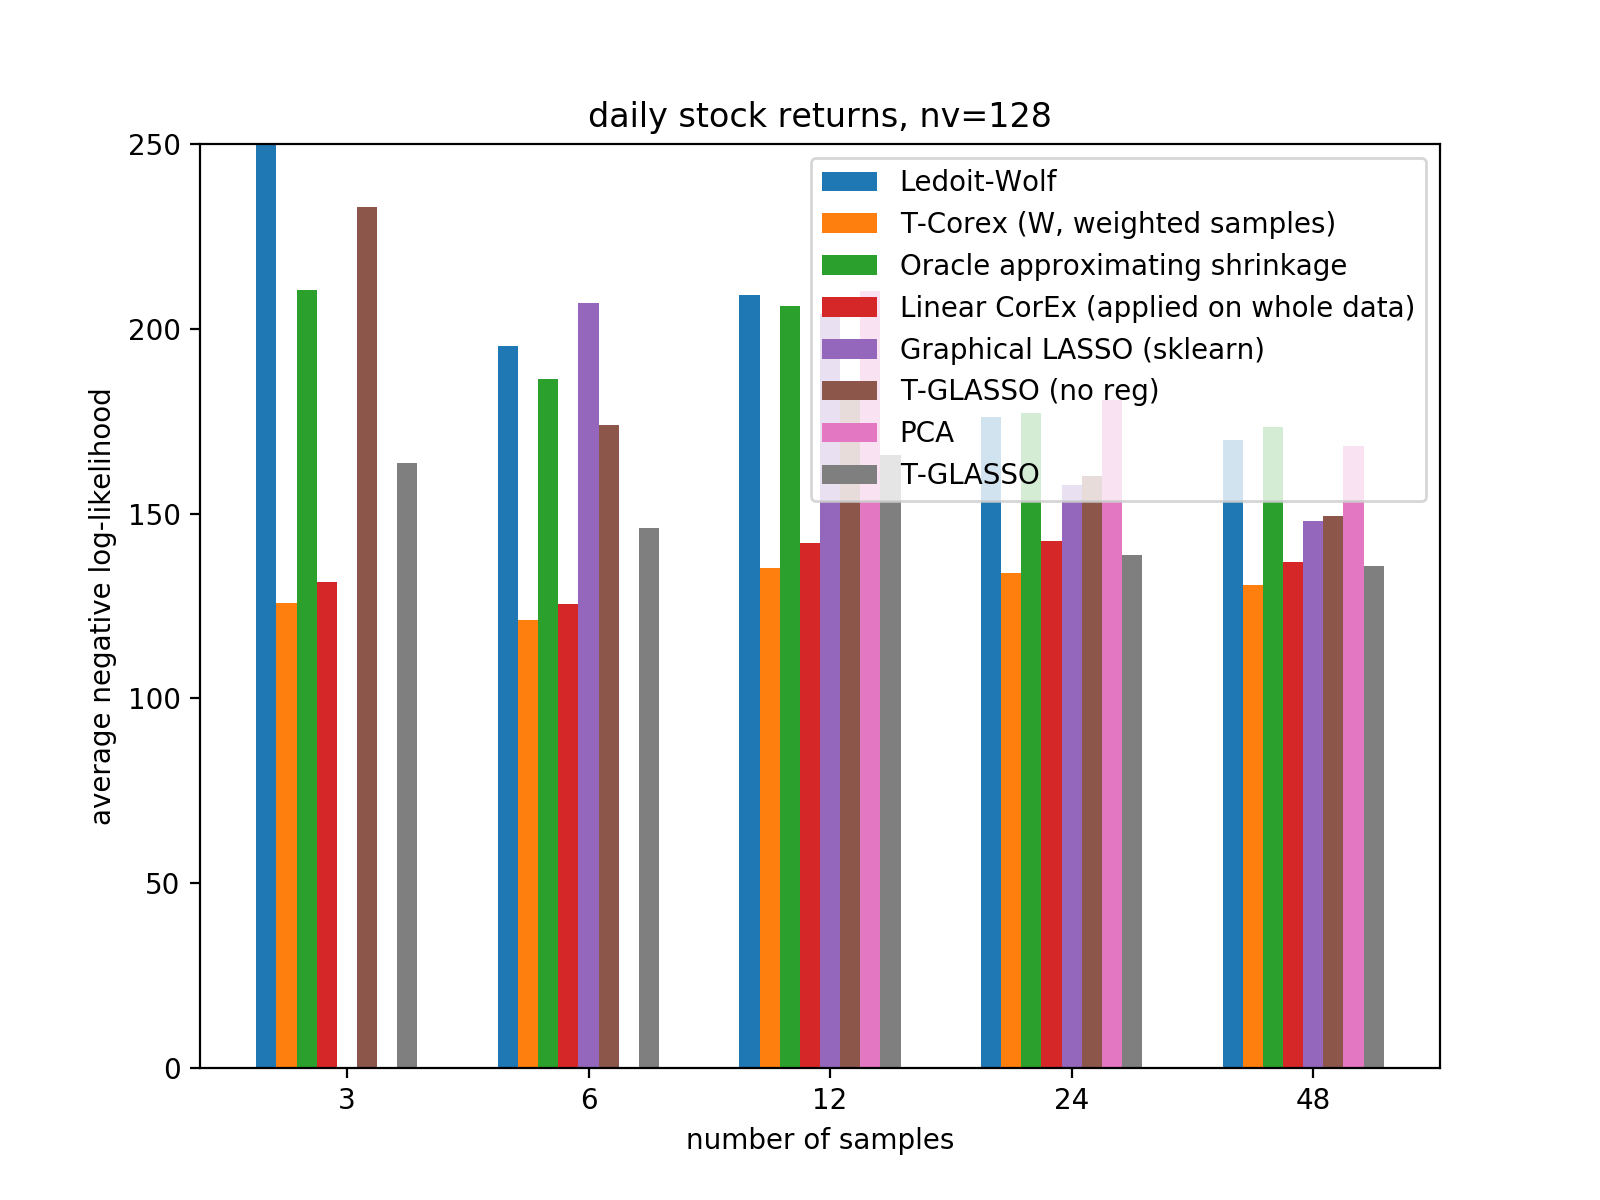

In [12]:
sizes = [3, 6, 12, 24, 48]

show_methods = ['Ledoit-Wolf',
#                 'Factor Analysis',
                'T-Corex (W, weighted samples)',
#                 'T-Corex (W, weighted samples, no reg)',
#                 'T-Corex (W)',
#                 'Diagonal',
                'Oracle approximating shrinkage',
#                 'Linear CorEx (applied on buckets)',
                'Linear CorEx (applied on whole data)',
                'Graphical LASSO (sklearn)',
                'T-GLASSO (no reg)',
                'PCA',
                'T-GLASSO']

visualize_case_barplot(stock_day_64, 'daily stock returns, nv=64', show_methods, {}, sizes, yrange=(0,200))
visualize_case_barplot(stock_day_128, 'daily stock returns, nv=128', show_methods, {}, sizes, yrange=(0,250))

<IPython.core.display.Javascript object>


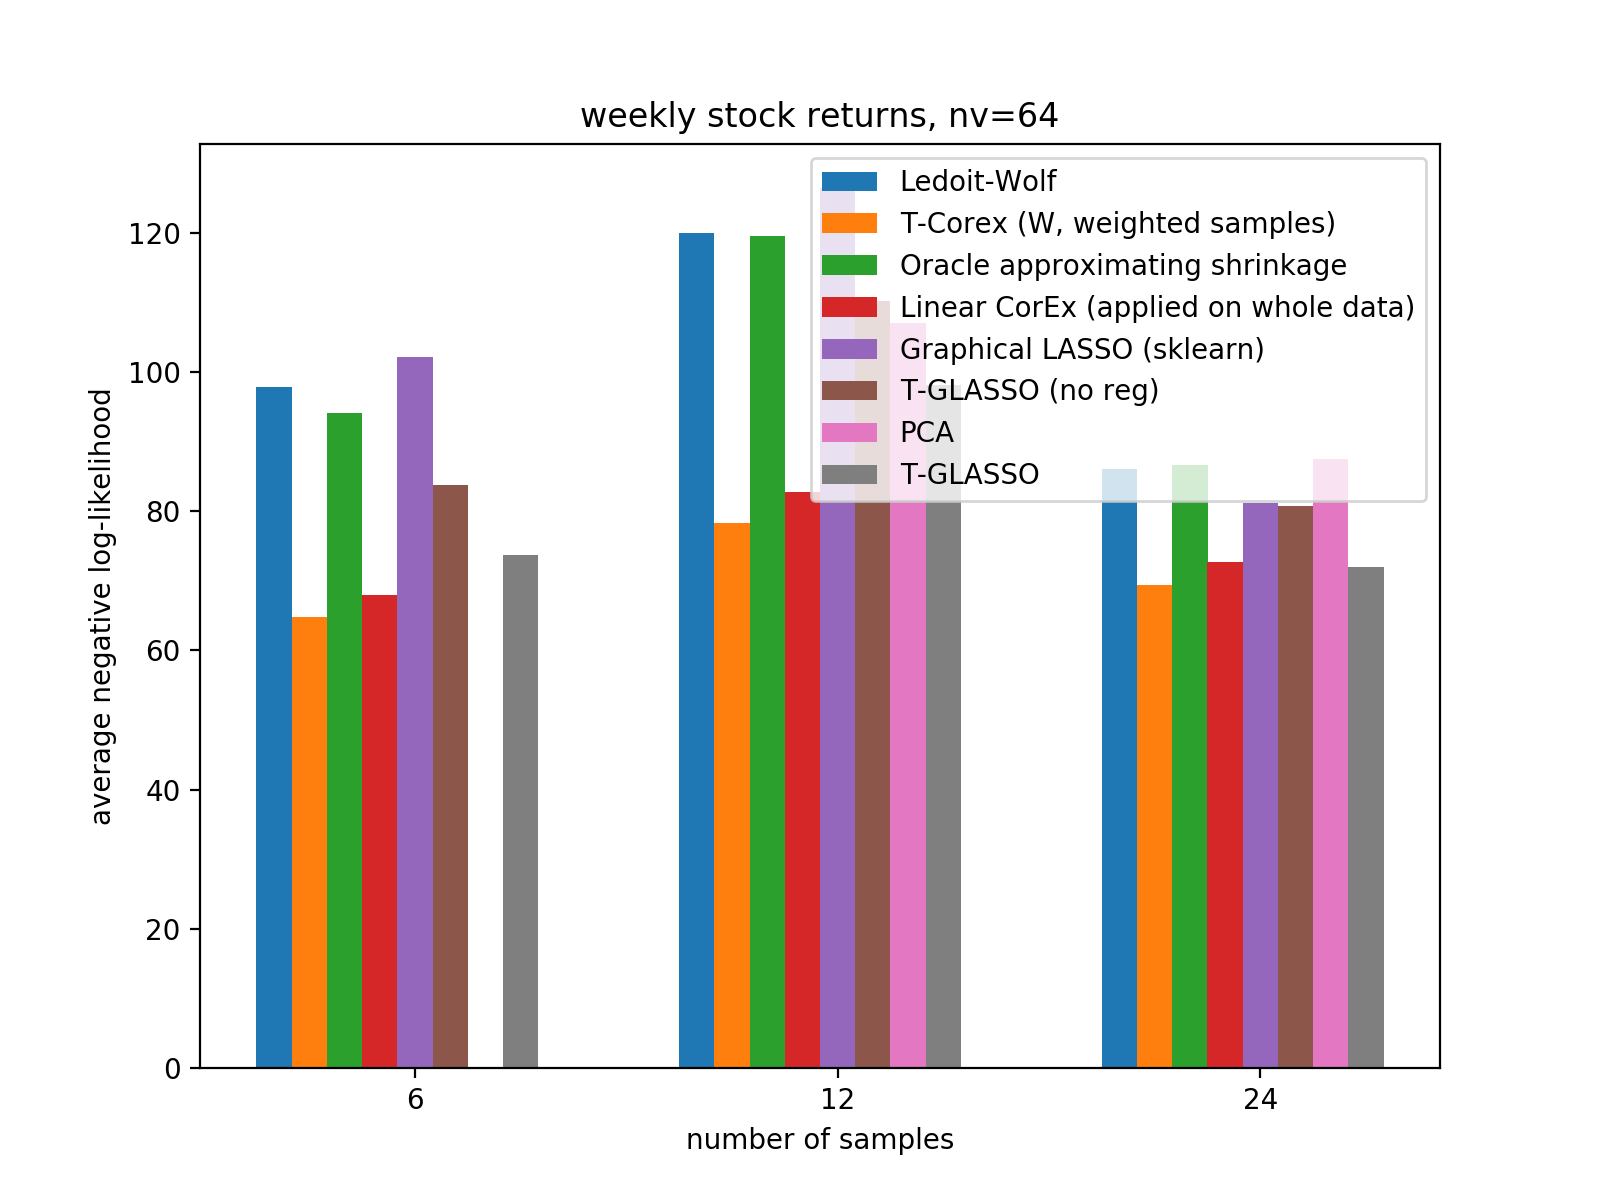

<IPython.core.display.Javascript object>


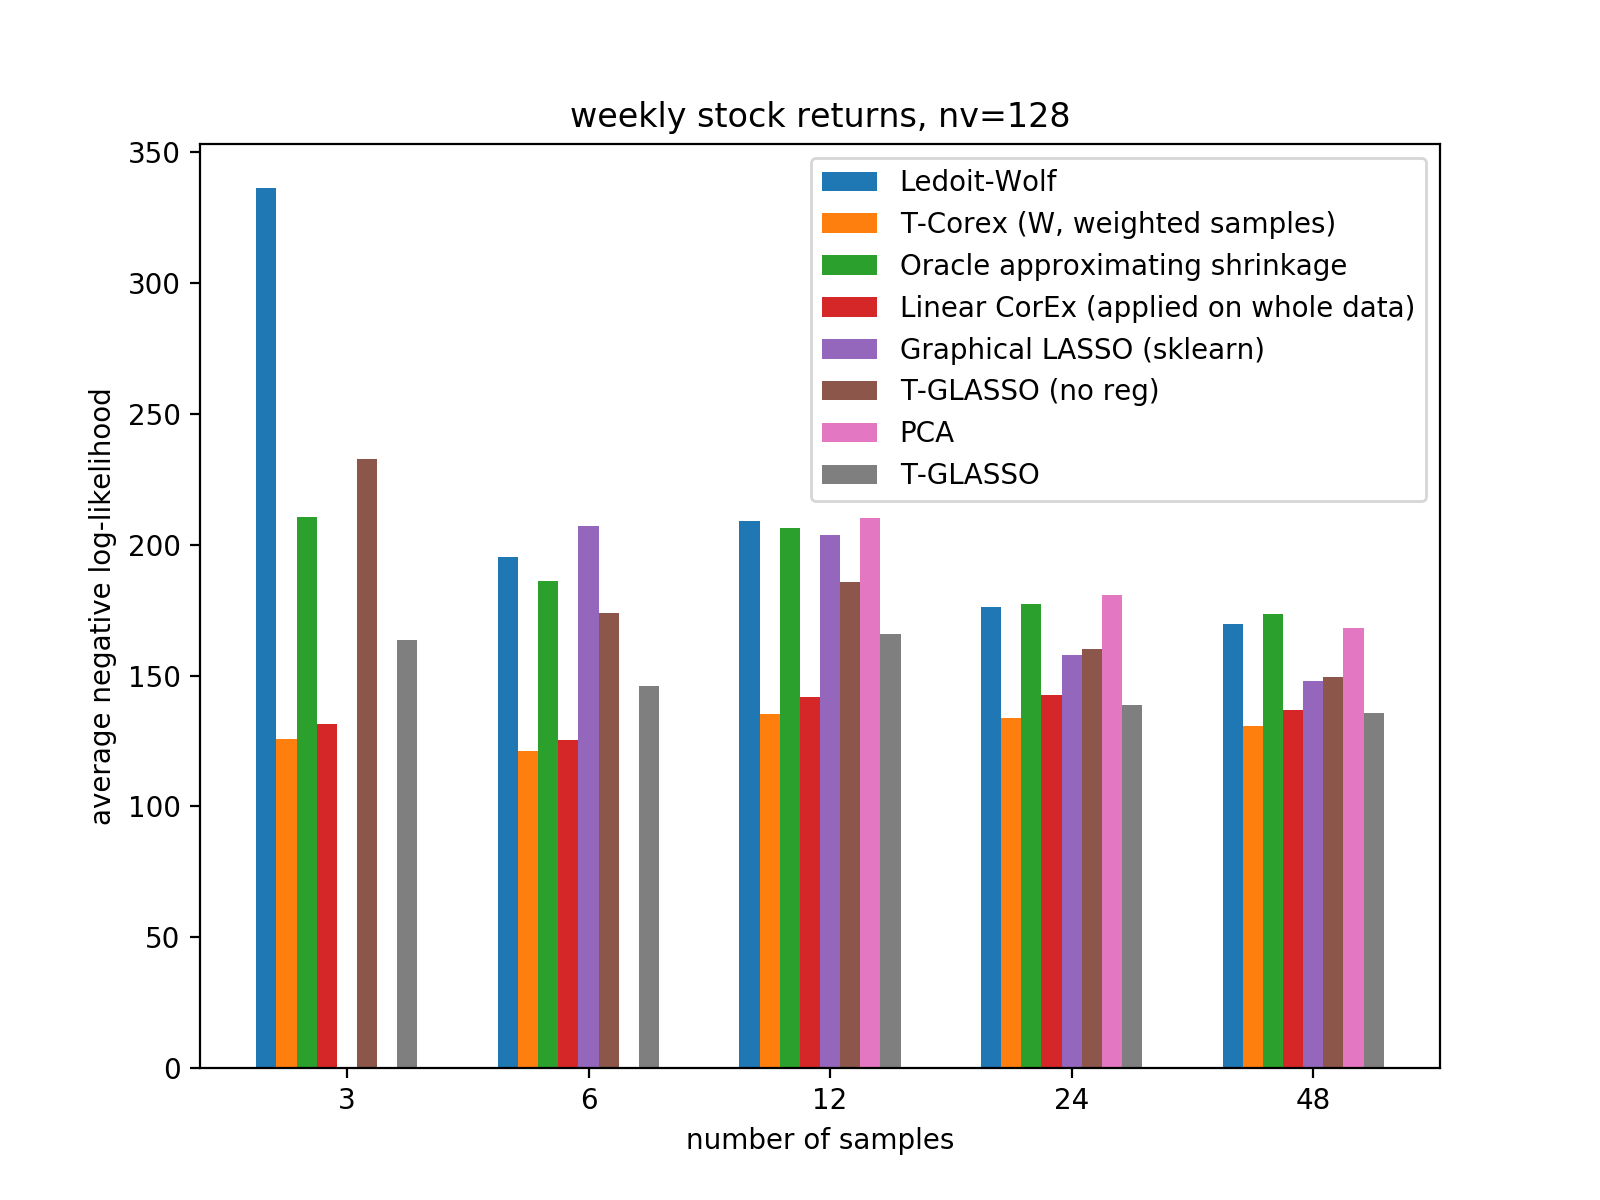

In [9]:
sizes = [3, 6, 12, 24, 48]

show_methods = ['Ledoit-Wolf',
#                 'Factor Analysis',
                'T-Corex (W, weighted samples)',
#                 'T-Corex (W, weighted samples, no reg)',
#                 'T-Corex (W)',
#                 'Diagonal',
                'Oracle approximating shrinkage',
#                 'Linear CorEx (applied on buckets)',
                'Linear CorEx (applied on whole data)',
                'Graphical LASSO (sklearn)',
                'T-GLASSO (no reg)',
                'PCA',
                'T-GLASSO']

visualize_case_barplot(stock_week_64, 'weekly stock returns, nv=64', show_methods, {}, sizes[1:-1], yrange=None)
visualize_case_barplot(stock_day_128, 'weekly stock returns, nv=128', show_methods, {}, sizes, yrange=None)

#### Barplots

In [3]:
def bar_plot_baselines(jsonfile, title):
    with open(jsonfile) as f:
        data = json.load(f)
    keys = data.keys()
    keys = sorted(keys)
    plt.figure(figsize=(9,7))
    values = [data[k]['mean'] for k in keys]
    values = [0 if np.isinf(x) else x for x in values]
    plt.bar(range(len(keys)), values, width=0.6)
    plt.ylim(0.9*data['Ground Truth']['mean'])
    plt.xticks(range(len(keys)), keys, rotation=90)
    for i, v in enumerate(values):
        plt.text(i - 0.4, v+1, '{:.2f}'.format(v))
    plt.tight_layout()
    plt.title(title)
    plt.subplots_adjust(top=0.9)
    plt.show()
        

In [ ]:
bar_plot_baselines(A1_C3[0], "m=8,bs=16 time-series")

<IPython.core.display.Javascript object>


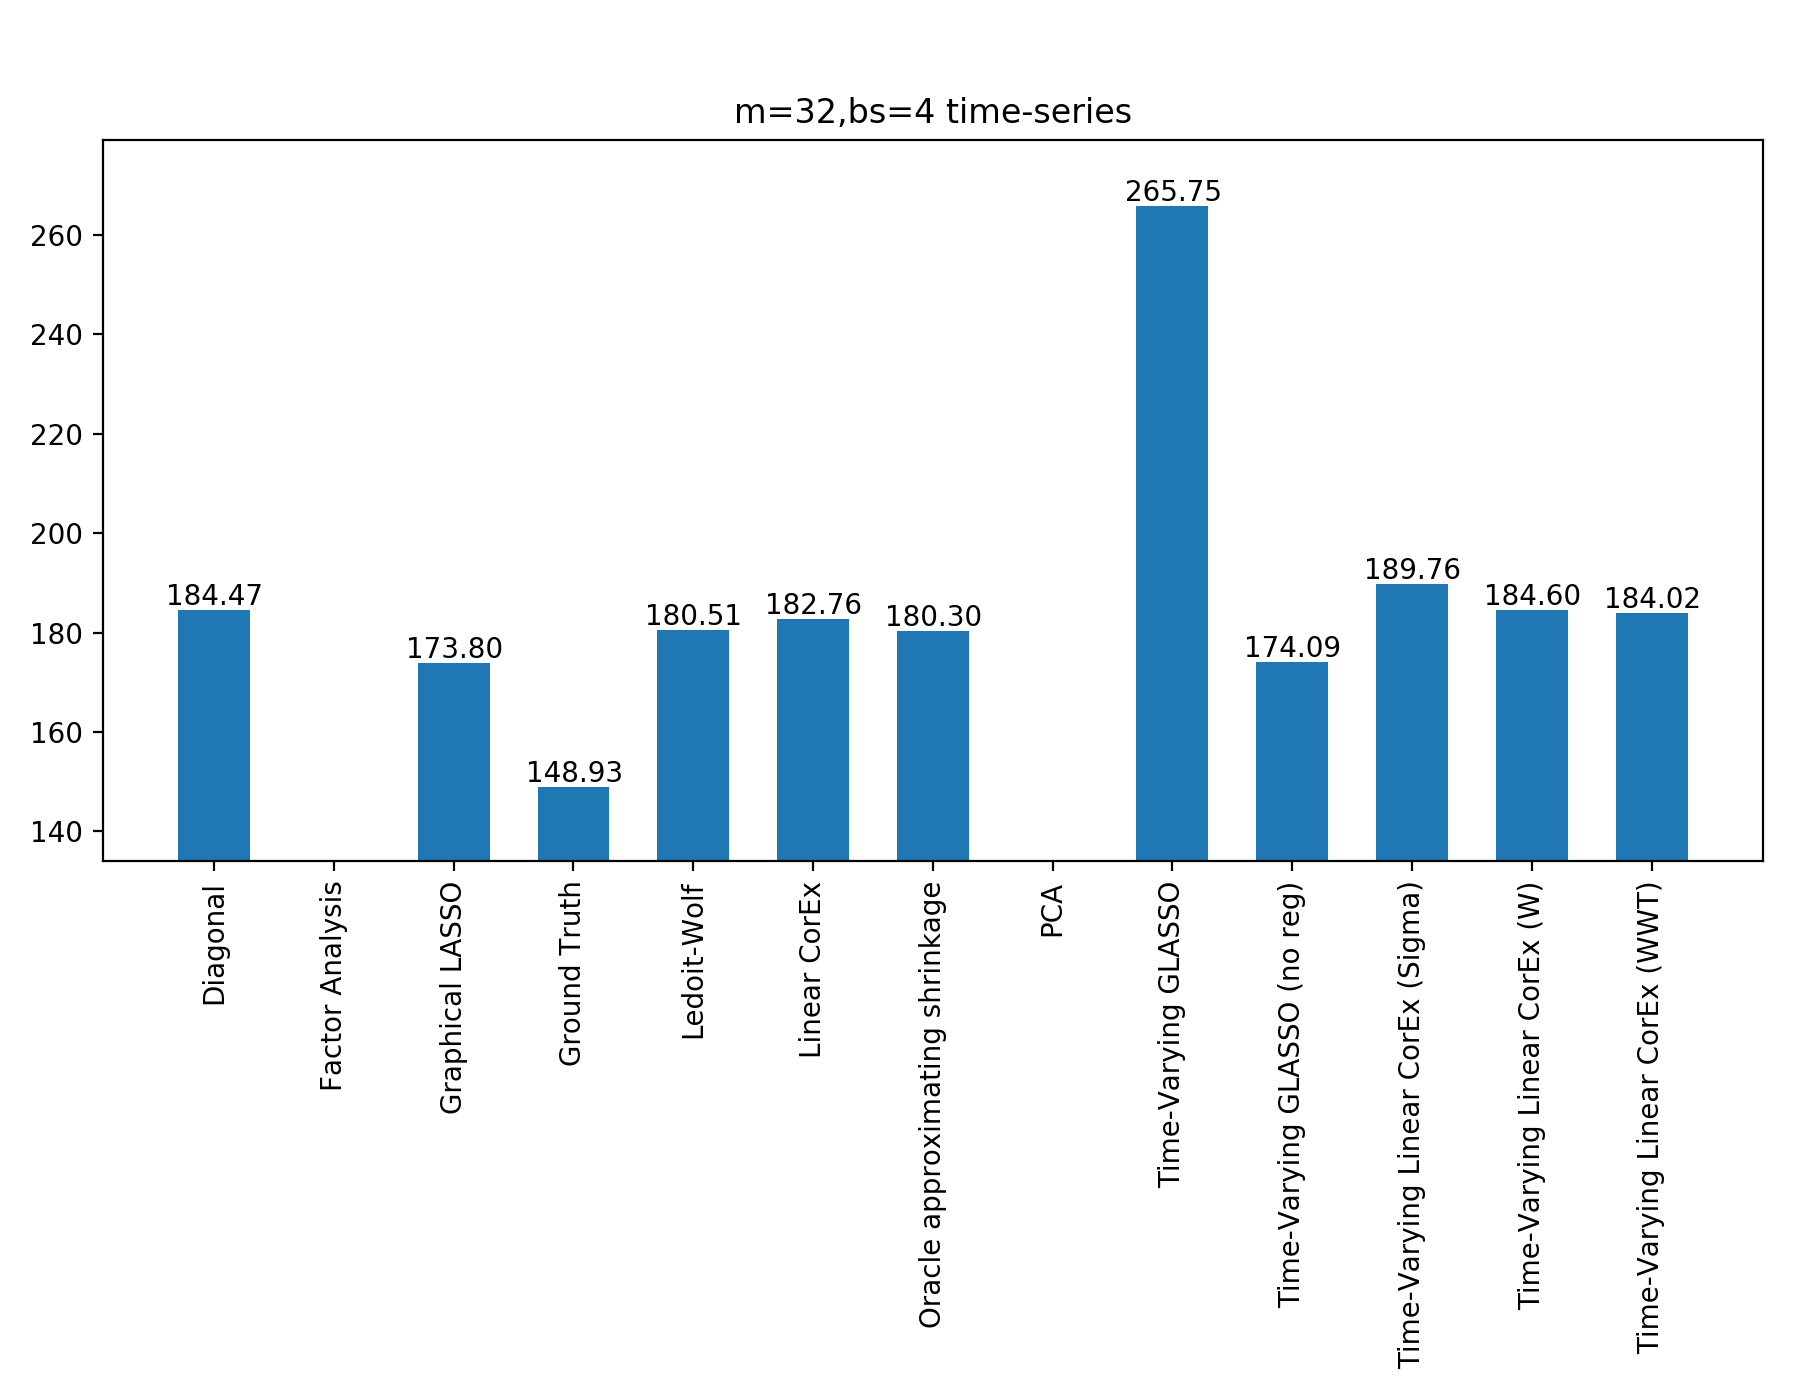

In [39]:
bar_plot_baselines(A2_C3[1], "m=32,bs=4 time-series")

In [46]:
A1_C1_change_structure = [
    'results/change_structure.syn_nglf_buckets.nt10.m8.bs16.train_cnt16.val_cnt16.test_cnt100.min_cor0.60.max_cor1.00.results.json',
    'results/change_structure.syn_nglf_buckets.nt10.m8.bs16.train_cnt32.val_cnt16.test_cnt100.min_cor0.60.max_cor1.00.results.json',
    'results/change_structure.syn_nglf_buckets.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt100.min_cor0.60.max_cor1.00.results.json'
]

<IPython.core.display.Javascript object>


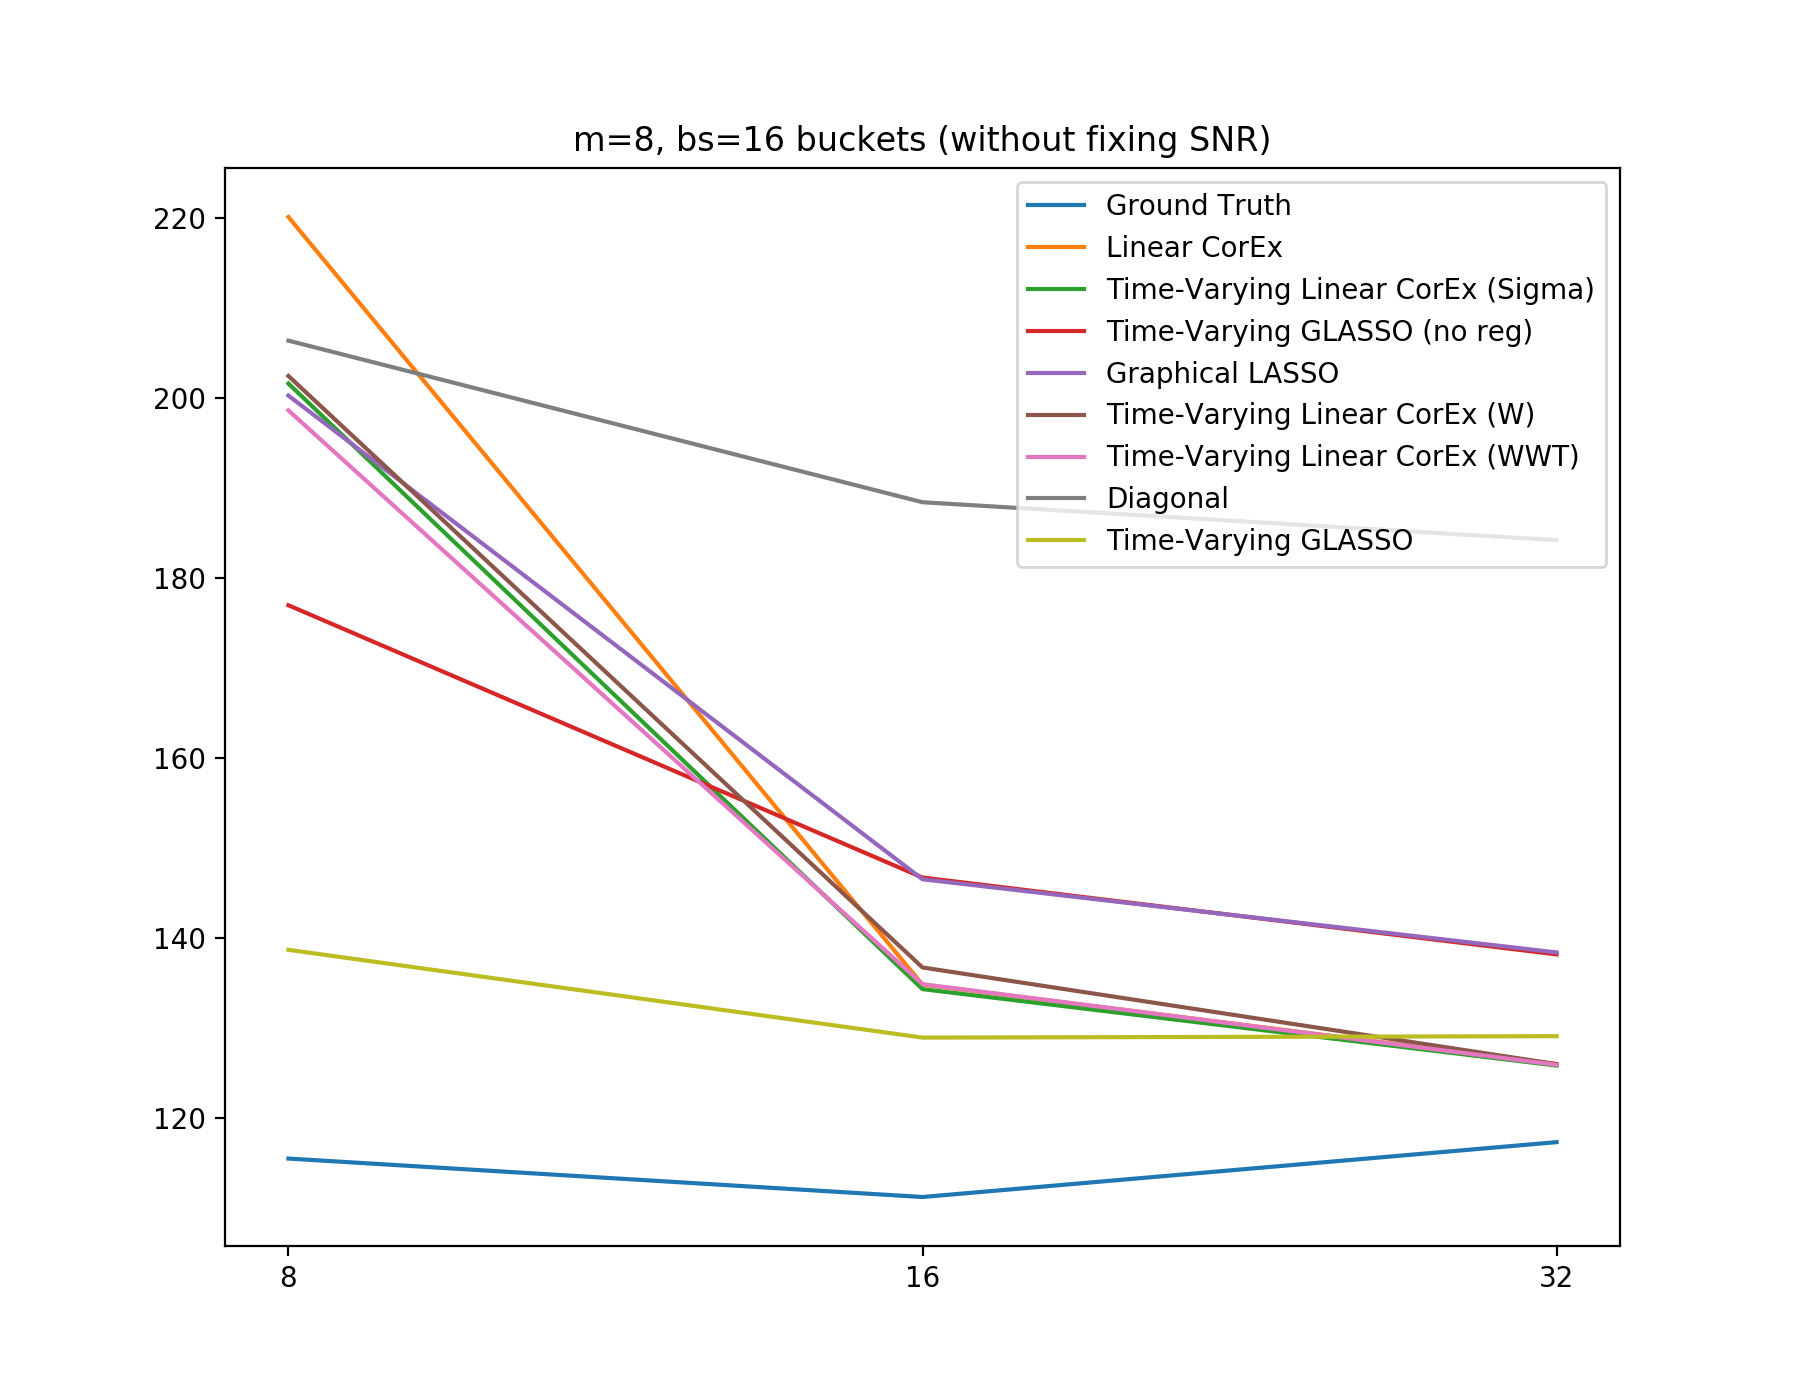

In [47]:
visualize_case(A1_C1_change_structure, 'm=8, bs=16 buckets (without fixing SNR)')

# draft

<IPython.core.display.Javascript object>


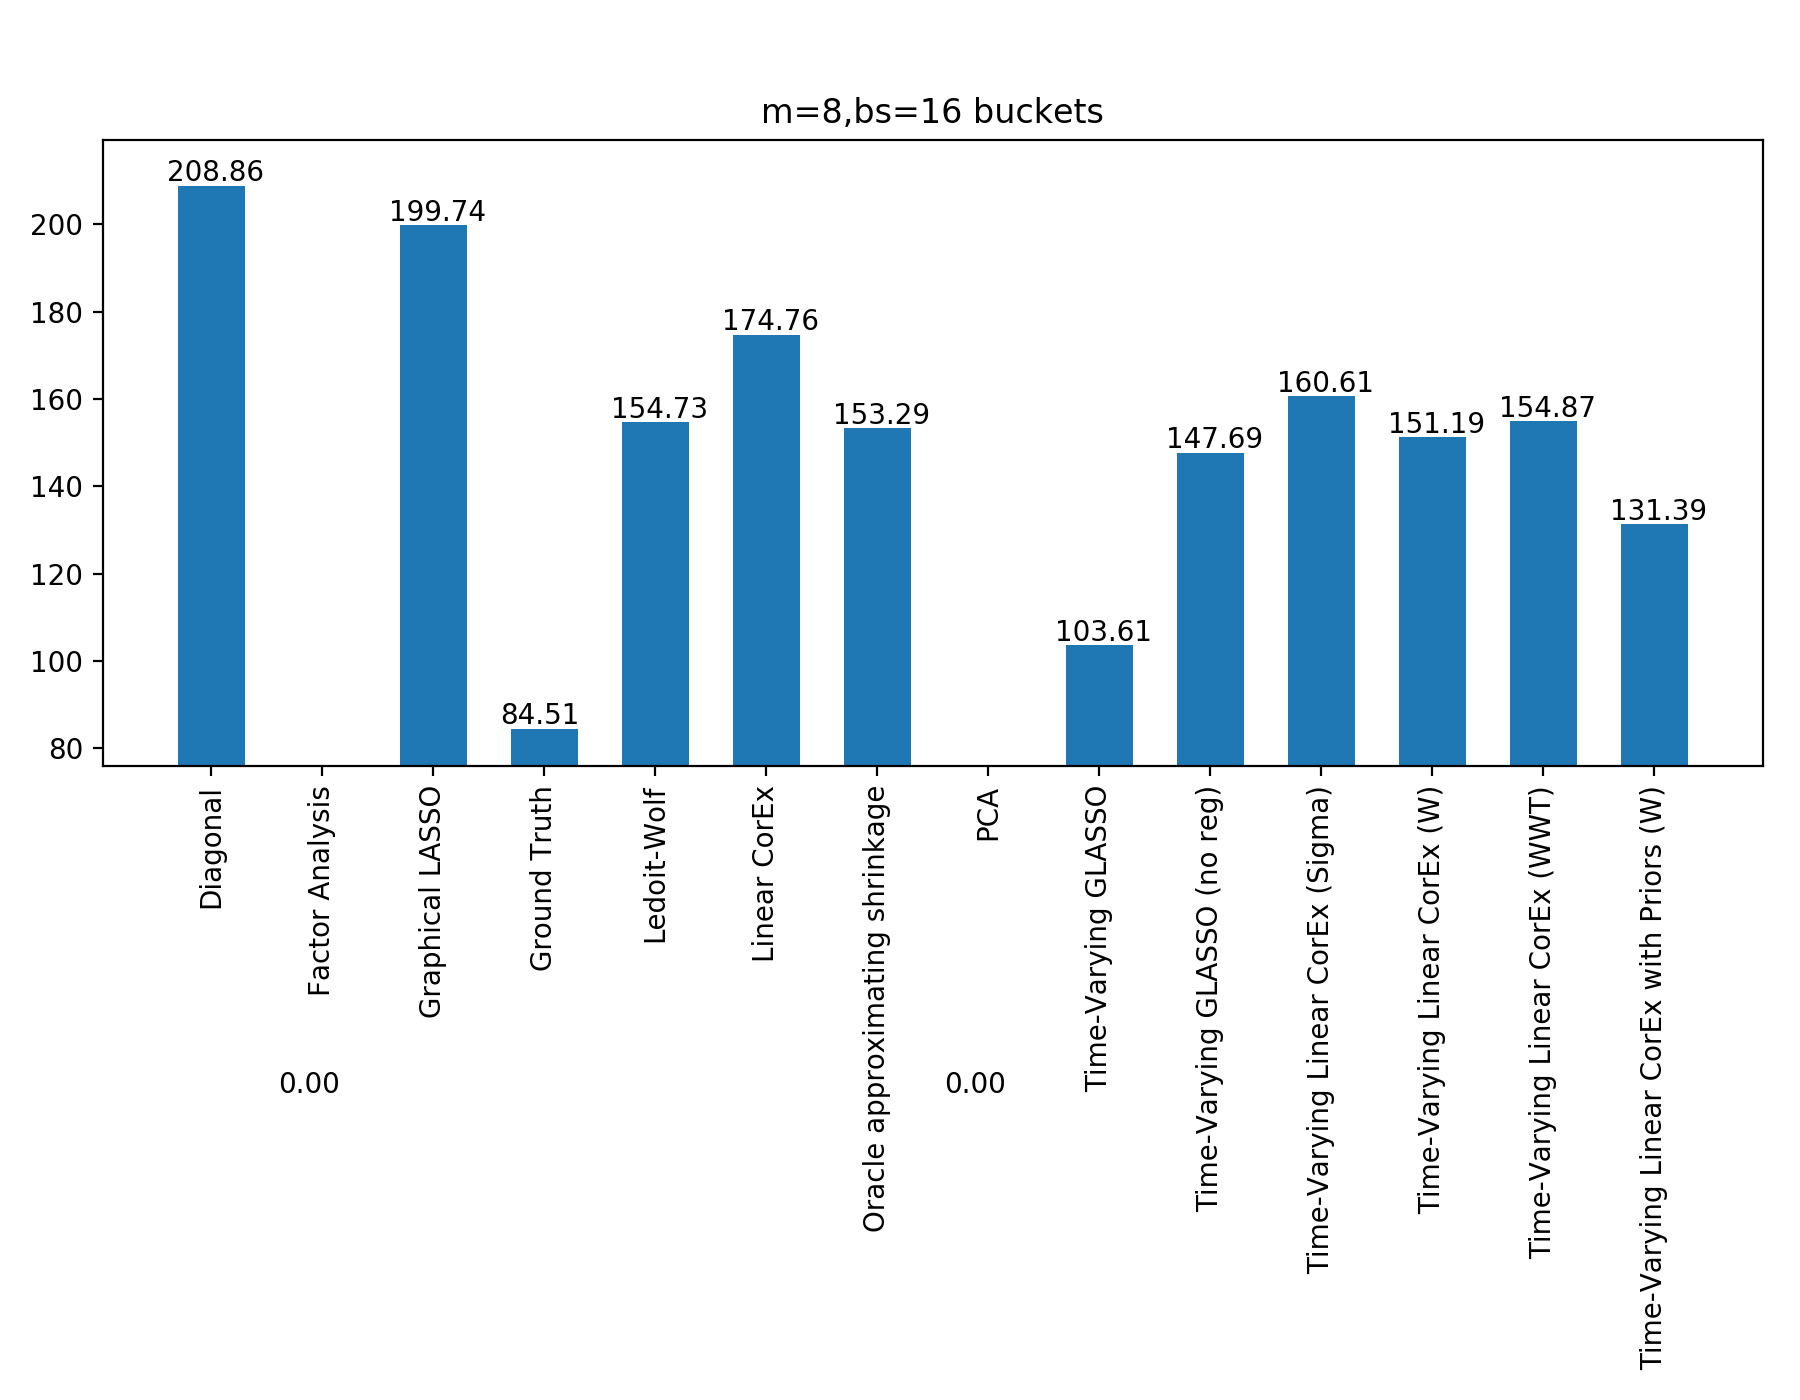

In [64]:
bar_plot_baselines('results/syn_nglf_buckets.nt10.m8.bs16.train_cnt8.val_cnt16.test_cnt100.snr5.00.results.json',
                   'm=8,bs=16 buckets')